<a href="https://colab.research.google.com/github/Emersonmiady/bootcamp-alura-ds/blob/main/modulo_4/analise_e_previsao_de_series_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pmdarima

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

# Módulo 4

## O que é série temporal?
É uma sequência de observações, as quais apresentam um certo **padrão** conforme se passa o tempo, de forma regularizada (exemplo: mês, ano...).

## Quais são os objetivos?
**Identificar padrões** é o objetivo principal. Sendo assim, dado um padrão descoberto, conseguimos **fazer previsões** a partir do passado.

## Um pouco sobre estacionariedade

### O que é?
A série ser **estacionária** significa que os pontos "flutuam" ao redor de uma determinada:
- **Média constante**;
- **Variância constante**;
- **Auto-covariância independente do tempo**.

Com essas condições, temos a garantia estatística para aplicar nossos modelos.

Já quando a série é **não estacionária**, significa que apresenta dois componentes, **tendência** e **sazonalidade**.

- **Sazonalidade**: se trata de **entender os padrões que se repete conforme o tempo se passa**;
- **Tendência**: basicamente se refere ao **como** aquele padrão está progredindo. Por exemplo, se quela linha tem uma tendência de subida ou de descida.

Porém, quando existem esses dois fatores, fica realmente muito complexo de se tirar alguma análise. 

### Como saber se é estacionária

Podemos bater o olho em uma determinada série e dizer, com convicção, que ela não é estacionária. Entretanto nem toda série é assim! Para identificarmos esse fator, podemos utilizar um teste estatístico, como (um deles já basta):
- **Teste Dickey-Fuller**;
- **Teste de Philips-Perron**;
- **Teste KPSS**.

### E se não for?
Alguns modelos estatísticos **necessitam** que a série seja **estacionária**, como o ARIMA (comentado mais adiante). Se ela não for, podemos transformá-la em estacionária, utilizando uma das técnicas seguintes:

1. Podemos diferenciar os dados. Isto é, dada a série $Z_t$, criamos a nova série

  - $Y_i = Z_i - Z_{i-1}$

  Os dados diferenciados conterão um ponto a menos que os dados originais. Embora você possa diferenciar os dados mais que uma vez, uma ou duas diferenciações geralmente são suficientes (normalmente a de 1 é mais utilizada).

  **Observação 1:** $\Delta^nZ(t) = \Delta[\Delta^{n−1}Z(t)]$ é a fórmula para descobrir a n-ésima diferença de Z(t).

  **Observação 2:** Este item (1) é o mais recorrente para transformar a série em estacionária.

2. Se os dados tiverem uma tendência, podemos ajustar algum tipo de curva aos dados e depois então modelar os resíduos daquele ajuste. Desde que o propósito do ajuste é simplesmente remover tendências de longo prazo, um ajuste simples, tal como uma linha reta, é tipicamente usado.

3. Para variância não constante, tomando o logarítmo ou a raiz quadrada da série pode estabilizar a variância. Para dados negativos, você pode adicionar uma constante adequada para tornar todos os dados positivos antes de aplicar a transformação. Esta constante pode então ser subtraída do modelo para obter valores previstos (i.e., ajustados) e previsões para pontos futuros.


Mais informações: 
- https://www.alura.com.br/artigos/series-temporais-e-suas-aplicacoes
- https://www.alura.com.br/artigos/modelos-matematicos-utilizados-em-series-temporais
- https://www.youtube.com/watch?v=u-YYgigBxqo
- http://www.bertolo.pro.br/MetodosQuantitativos/Previsao/pmc442.htm
- https://www.youtube.com/watch?v=qTQ1YDgyByE

## 01. Série temporal

In [ ]:
url = 'https://raw.githubusercontent.com/alura-cursos/serie_temporal_bootcamp/main/tuberculose_ano_mes_diagnostico.csv'

dados = pd.read_csv(url, encoding='ISO-8859-1', sep=';', skiprows=3, skipfooter=16,
                 engine='python')
dados.head()

Ano Diagnóstico   Jan   Fev   Mar   Abr  ...   Set   Out   Nov   Dez  Total
0            2001  8088  6542  8095  7305  ...  6697  7524  6874  6627  87265
1            2002  8013  7346  7961  8771  ...  7654  8200  7532  6809  92859
2            2003  8115  7985  7474  7975  ...  8136  8521  7624  7303  93773
3            2004  7574  6743  8574  8089  ...  7901  8016  7753  7196  92980
4            2005  7432  6748  8441  7958  ...  7690  7186  7587  7541  92056

[5 rows x 14 columns]

In [ ]:
dados.tail()

Ano Diagnóstico     Jan     Fev     Mar  ...     Out     Nov     Dez    Total
15            2016    7116    6800    8067  ...    6588    7039    6672    86207
16            2017    7481    6803    8680  ...    7809    7451    7020    90291
17            2018    7881    6821    7901  ...    8701    7711    6900    94354
18            2019    8392    7754    7648  ...    8592    7615    7220    96005
19           Total  142969  129386  149875  ...  144870  136864  128893  1684757

[5 rows x 14 columns]

### Desafio 01: Transformar os dados em uma série temporal Ano-Mês.

### Desafio 02: Converter a data (String) em Datetime.

In [ ]:
dados.drop('Total', axis=1, inplace=True)
dados = dados[:-1]

In [ ]:
dados.tail()

Ano Diagnóstico   Jan   Fev   Mar   Abr  ...   Ago   Set   Out   Nov   Dez
14            2015  7111  6160  7833  6880  ...  7463  7189  7345  7287  6844
15            2016  7116  6800  8067  7360  ...  7702  7030  6588  7039  6672
16            2017  7481  6803  8680  6780  ...  8110  7447  7809  7451  7020
17            2018  7881  6821  7901  8121  ...  8934  7663  8701  7711  6900
18            2019  8392  7754  7648  8274  ...  8239  8143  8592  7615  7220

[5 rows x 13 columns]

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ano Diagnóstico  19 non-null     object
 1   Jan              19 non-null     int64 
 2   Fev              19 non-null     int64 
 3   Mar              19 non-null     int64 
 4   Abr              19 non-null     int64 
 5   Mai              19 non-null     int64 
 6   Jun              19 non-null     int64 
 7   Jul              19 non-null     int64 
 8   Ago              19 non-null     int64 
 9   Set              19 non-null     int64 
 10  Out              19 non-null     int64 
 11  Nov              19 non-null     int64 
 12  Dez              19 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 2.1+ KB


In [ ]:
dados['Ano Diagnóstico'] = pd.to_numeric(dados['Ano Diagnóstico'])
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Ano Diagnóstico  19 non-null     int64
 1   Jan              19 non-null     int64
 2   Fev              19 non-null     int64
 3   Mar              19 non-null     int64
 4   Abr              19 non-null     int64
 5   Mai              19 non-null     int64
 6   Jun              19 non-null     int64
 7   Jul              19 non-null     int64
 8   Ago              19 non-null     int64
 9   Set              19 non-null     int64
 10  Out              19 non-null     int64
 11  Nov              19 non-null     int64
 12  Dez              19 non-null     int64
dtypes: int64(13)
memory usage: 2.1 KB


In [ ]:
meses = dados.columns[1:]
dicionario_meses = {}

contador_dos_meses = 1
for mes in meses:
  dicionario_meses[mes] = contador_dos_meses
  contador_dos_meses += 1

print(dicionario_meses)

{'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12}


In [ ]:
dados_st = dados.melt(id_vars='Ano Diagnóstico', value_name='Casos', var_name='Mês')
dados_st['Mês'] = dados_st['Mês'].map(dicionario_meses)
dados_st

Ano Diagnóstico  Mês  Casos
0               2001    1   8088
1               2002    1   8013
2               2003    1   8115
3               2004    1   7574
4               2005    1   7432
..               ...  ...    ...
223             2015   12   6844
224             2016   12   6672
225             2017   12   7020
226             2018   12   6900
227             2019   12   7220

[228 rows x 3 columns]

In [ ]:
dados_st['Data'] = dados_st['Ano Diagnóstico'].map(str)+'-'+dados_st['Mês'].map(str)
dados_st

Ano Diagnóstico  Mês  Casos     Data
0               2001    1   8088   2001-1
1               2002    1   8013   2002-1
2               2003    1   8115   2003-1
3               2004    1   7574   2004-1
4               2005    1   7432   2005-1
..               ...  ...    ...      ...
223             2015   12   6844  2015-12
224             2016   12   6672  2016-12
225             2017   12   7020  2017-12
226             2018   12   6900  2018-12
227             2019   12   7220  2019-12

[228 rows x 4 columns]

In [ ]:
dados_st['Data'] = pd.to_datetime(dados_st['Data'], format='%Y-%m')
dados_st['Mês'] = dados_st['Data'].dt.strftime('%b')
dados_st['String_data'] = dados_st['Data'].dt.strftime('%Y-%b')

dados_st

Ano Diagnóstico  Mês  Casos       Data String_data
0               2001  Jan   8088 2001-01-01    2001-Jan
1               2002  Jan   8013 2002-01-01    2002-Jan
2               2003  Jan   8115 2003-01-01    2003-Jan
3               2004  Jan   7574 2004-01-01    2004-Jan
4               2005  Jan   7432 2005-01-01    2005-Jan
..               ...  ...    ...        ...         ...
223             2015  Dec   6844 2015-12-01    2015-Dec
224             2016  Dec   6672 2016-12-01    2016-Dec
225             2017  Dec   7020 2017-12-01    2017-Dec
226             2018  Dec   6900 2018-12-01    2018-Dec
227             2019  Dec   7220 2019-12-01    2019-Dec

[228 rows x 5 columns]

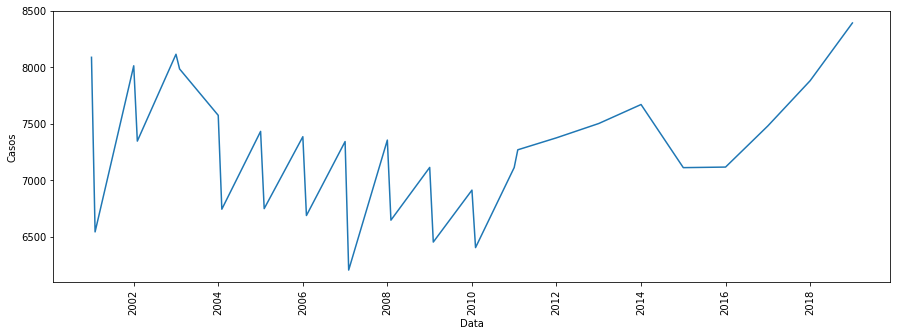

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st[:30])
plt.xticks(rotation=90)
plt.show()

In [ ]:
dados_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ano Diagnóstico  228 non-null    int64         
 1   Mês              228 non-null    object        
 2   Casos            228 non-null    int64         
 3   Data             228 non-null    datetime64[ns]
 4   String_data      228 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.0+ KB


## 02. Manipulação de datas

In [ ]:
dados_st = dados_st[['Data', 'Casos']]
dados_st.head()

Data  Casos
0 2001-01-01   8088
1 2002-01-01   8013
2 2003-01-01   8115
3 2004-01-01   7574
4 2005-01-01   7432

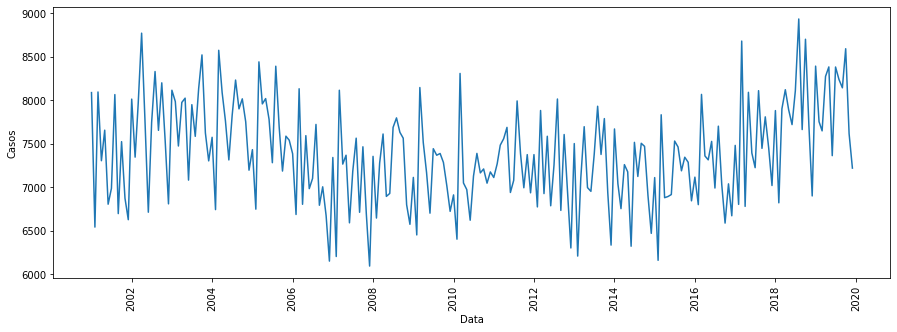

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st)
plt.xticks(rotation=90)
plt.show()

### Desafio 01 - Faça a mesma transformação realizada em aula nas datas para a base de dados de Hanseníase.

In [ ]:
caminho_drive = '/content/drive/MyDrive/Alura Bootcamp DS/Módulo 4/hanseniase.csv'

hanseniase = pd.read_csv(caminho_drive, sep=';', encoding='ISO-8859-1',
                         skiprows=3, skipfooter=10)
hanseniase.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


Ano Diagnóstico Jan Fev Mar Abr Mai Jun Jul Ago Set Out Nov Dez  Total
0           <1975  28   8  12  14  14  17  17  14  12  23  21  21    201
1            1975   -   1   -   -   -   -   -   -   -   -   -   1      2
2            1976   -   -   -   2   1   2   -   -   2   -   1   -      8
3            1977   2   -   -   1   -   -   -   -   -   1   1   -      5
4            1978   -   -   -   -   -   2   1   2   -   1   -   -      6

In [ ]:
hanseniase.tail()

Ano Diagnóstico    Jan    Fev    Mar  ...    Out    Nov    Dez   Total
42            2016   2393   2540   3000  ...   2644   2528   2213   32190
43            2017   2585   2718   3162  ...   3275   2961   2448   34638
44            2018   2971   2877   3276  ...   3423   2909   2268   36925
45            2019   3105   3319   2804  ...   3137   2715   1886   34640
46           Total  65734  70144  77916  ...  74193  69505  56957  849993

[5 rows x 14 columns]

In [ ]:
hanseniase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ano Diagnóstico  47 non-null     object
 1   Jan              47 non-null     object
 2   Fev              47 non-null     object
 3   Mar              47 non-null     object
 4   Abr              47 non-null     object
 5   Mai              47 non-null     object
 6   Jun              47 non-null     object
 7   Jul              47 non-null     object
 8   Ago              47 non-null     object
 9   Set              47 non-null     object
 10  Out              47 non-null     object
 11  Nov              47 non-null     object
 12  Dez              47 non-null     object
 13  Total            47 non-null     int64 
dtypes: int64(1), object(13)
memory usage: 5.3+ KB


In [ ]:
hanseniase = hanseniase[27:-1]
hanseniase.drop('Total', axis=1, inplace=True)

In [ ]:
hanseniase.head()

Ano Diagnóstico   Jan   Fev   Mar   Abr  ...   Ago   Set   Out   Nov   Dez
27            2001  4107  4103  4787  4135  ...  4890  4035  4728  4197  3250
28            2002  3982  4065  4566  5027  ...  5281  4805  5151  4679  3545
29            2003  4127  5918  5555  4965  ...  4844  5249  5257  4737  3874
30            2004  4168  4169  5612  4557  ...  5640  4825  4233  4520  3925
31            2005  4078  4241  4998  4628  ...  5457  4853  5196  5008  4209

[5 rows x 13 columns]

In [ ]:
colunas_hanseniase = hanseniase.columns

for coluna in colunas_hanseniase:
  hanseniase[coluna] = pd.to_numeric(hanseniase[coluna])

In [ ]:
hanseniase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 27 to 45
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Ano Diagnóstico  19 non-null     int64
 1   Jan              19 non-null     int64
 2   Fev              19 non-null     int64
 3   Mar              19 non-null     int64
 4   Abr              19 non-null     int64
 5   Mai              19 non-null     int64
 6   Jun              19 non-null     int64
 7   Jul              19 non-null     int64
 8   Ago              19 non-null     int64
 9   Set              19 non-null     int64
 10  Out              19 non-null     int64
 11  Nov              19 non-null     int64
 12  Dez              19 non-null     int64
dtypes: int64(13)
memory usage: 2.1 KB


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Ano Diagnóstico  19 non-null     int64
 1   Jan              19 non-null     int64
 2   Fev              19 non-null     int64
 3   Mar              19 non-null     int64
 4   Abr              19 non-null     int64
 5   Mai              19 non-null     int64
 6   Jun              19 non-null     int64
 7   Jul              19 non-null     int64
 8   Ago              19 non-null     int64
 9   Set              19 non-null     int64
 10  Out              19 non-null     int64
 11  Nov              19 non-null     int64
 12  Dez              19 non-null     int64
dtypes: int64(13)
memory usage: 2.1 KB


In [ ]:
# Função para transformar dataframe em serie temporal
def transforma_df_em_serie_temporal(df):
  meses = df.columns[1:]
  dicionario_meses = {}

  contador_dos_meses = 1
  for mes in meses:
    dicionario_meses[mes] = contador_dos_meses
    contador_dos_meses += 1
  
  df_st = df.melt(id_vars='Ano Diagnóstico', value_name='Casos', 
                        var_name='Mês')
  df_st['Mês'] = df_st['Mês'].map(dicionario_meses)
  
  df_st['Data'] = df_st['Ano Diagnóstico'].map(str)+'-'+df_st['Mês'].map(str)
  df_st['Data'] = pd.to_datetime(df_st['Data'], format='%Y-%m')

  df_st['Mês'] = df_st['Data'].dt.strftime('%b')
  df_st['String_data'] = df_st['Data'].dt.strftime('%Y-%b')
  return df_st

In [ ]:
hanseniase = transforma_df_em_serie_temporal(hanseniase)
hanseniase.head()

Ano Diagnóstico  Mês  Casos       Data String_data
0             2001  Jan   4107 2001-01-01    2001-Jan
1             2002  Jan   3982 2002-01-01    2002-Jan
2             2003  Jan   4127 2003-01-01    2003-Jan
3             2004  Jan   4168 2004-01-01    2004-Jan
4             2005  Jan   4078 2005-01-01    2005-Jan

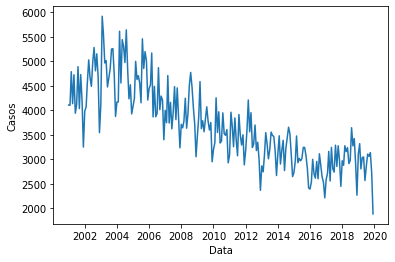

In [ ]:
sns.lineplot(x='Data', y='Casos', data=hanseniase)

### Desafio 02 - Configurar o gráfico de número de casos para deixá-lo mais elegante, analisar junto com um gráfico dos dados de hanseníase e compartilhar no discord suas hipóteses.

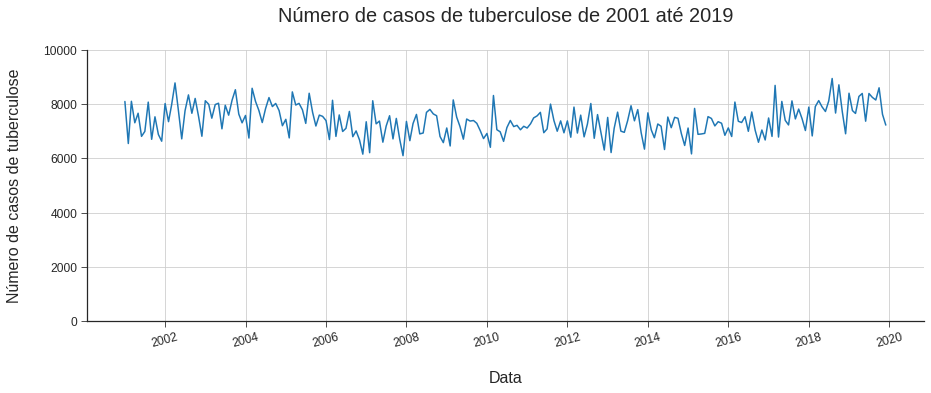

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

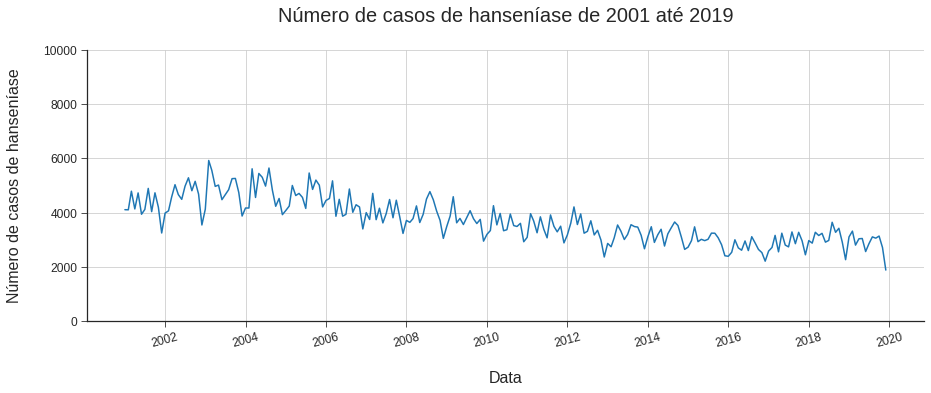

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=hanseniase)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de hanseníase\n', fontsize=16)
plt.title('Número de casos de hanseníase de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

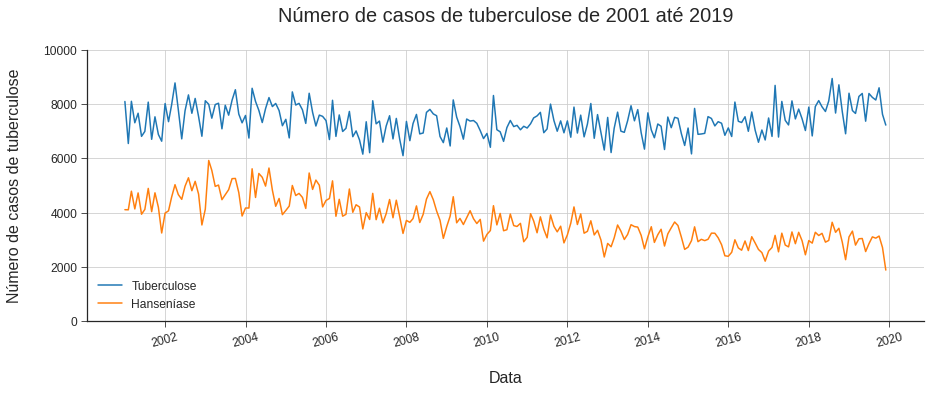

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st, label='Tuberculose')
sns.lineplot(x='Data', y='Casos', data=hanseniase, label='Hanseníase')
plt.legend(fontsize=12)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

## 03. Iniciando a Análise de Série Temporal

In [ ]:
dados_st.sort_values('Data', inplace=True)
dados_st.reset_index(drop=True, inplace=True)
dados_st.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Data  Casos
0 2001-01-01   8088
1 2001-02-01   6542
2 2001-03-01   8095
3 2001-04-01   7305
4 2001-05-01   7656

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


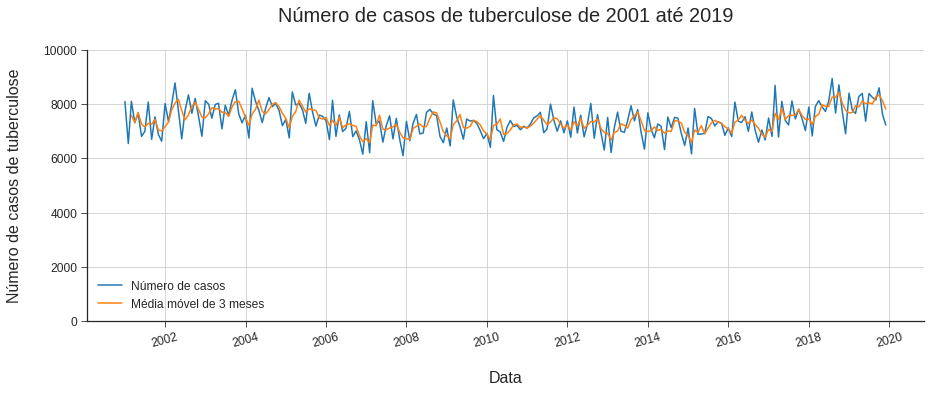

In [ ]:
# Comando para calcular a média móvel de 3 linhas atrás
dados_st['Media_Movel_3'] = dados_st['Casos'].rolling(3).mean()

plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st, label='Número de casos')
sns.lineplot(x='Data', y='Media_Movel_3', data=dados_st, 
             label='Média móvel de 3 meses')
plt.legend(fontsize=12)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


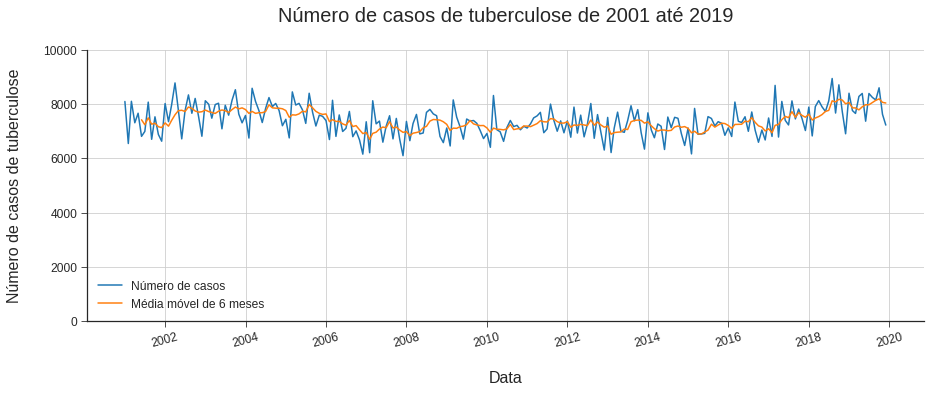

In [ ]:
dados_st['Media_Movel_6'] = dados_st['Casos'].rolling(6).mean()
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st, label='Número de casos')
sns.lineplot(x='Data', y='Media_Movel_6', data=dados_st, 
             label='Média móvel de 6 meses')
plt.legend(fontsize=12)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

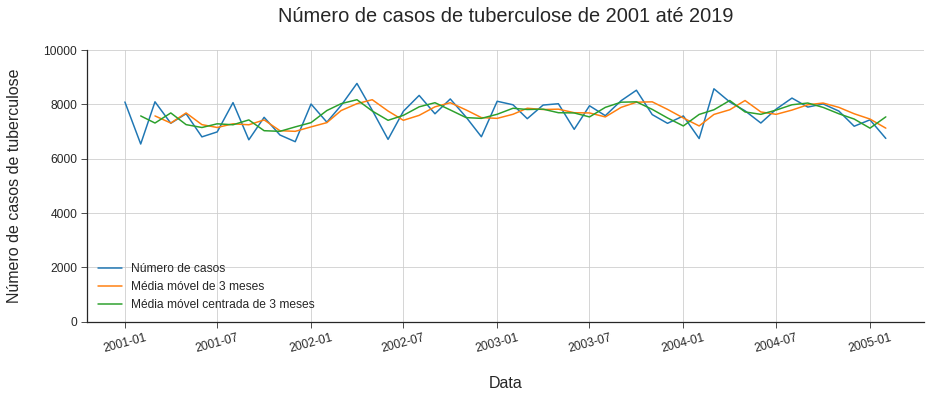

In [ ]:
dados_st['Media_Movel_3c'] = dados_st['Casos'].rolling(3, center=True).mean()
plt.figure(figsize=(15,5))
sns.lineplot(x='Data', y='Casos', data=dados_st[:50], label='Número de casos')
sns.lineplot(x='Data', y='Media_Movel_3', data=dados_st[:50], 
             label='Média móvel de 3 meses')
sns.lineplot(x='Data', y='Media_Movel_3c', data=dados_st[:50], 
             label='Média móvel centrada de 3 meses')
plt.legend(fontsize=12)
plt.ylim(0, 10000)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('\nData', fontsize=16)
plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
plt.grid()
sns.despine()
plt.show()

### Desafio Extra - Pesquisar o que é espectro de frequência.

### Desafio 01 - Analisar outras janelas de médias móveis, realizar a análise dessas janelas e compartilhar suas conclusões no Discord. Refletir sobre os impactos de uma suavização com janelas muito grandes.

In [ ]:
def mostra_serie_temporal_e_media_movel_tuberculose(df, quantidade):
  media_movel_str = f'Média_Móvel_{quantidade}c'
  df_copy = df.copy()
  df_copy[media_movel_str] = df_copy['Casos'].rolling(quantidade, center=True).mean()

  plt.figure(figsize=(15,5))
  sns.lineplot(x='Data', y='Casos', data=df_copy, label='Número de casos')
  sns.lineplot(x='Data', y=media_movel_str, data=df_copy, 
              label=f'Média móvel centrada de {quantidade} meses')
  plt.legend(fontsize=12)
  plt.ylim(0, 10000)
  plt.xticks(rotation=15, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('\nData', fontsize=16)
  plt.ylabel('Número de casos de tuberculose\n', fontsize=16)
  plt.title('Número de casos de tuberculose de 2001 até 2019\n', fontsize=20)
  plt.grid()
  sns.despine()
  plt.show()

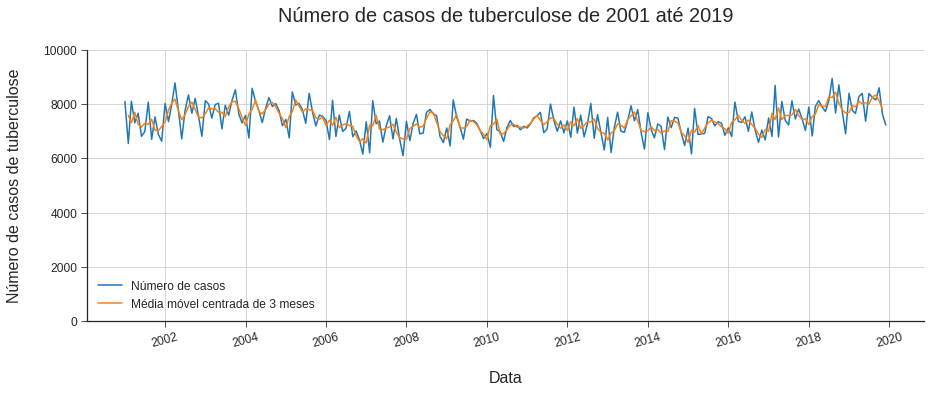

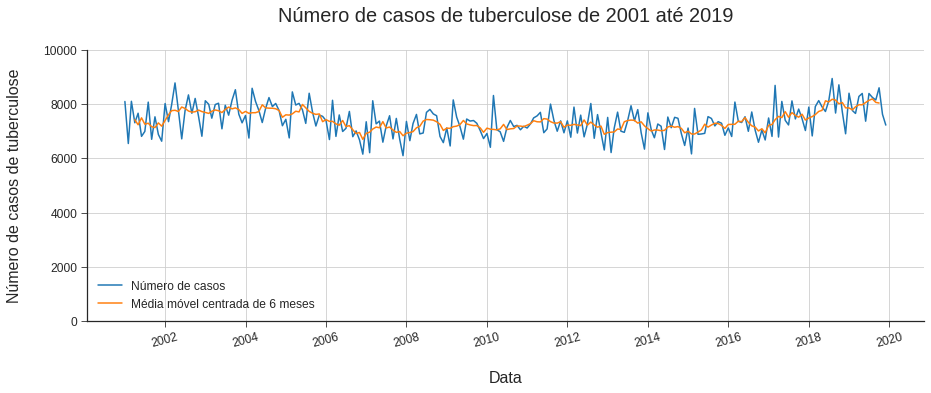

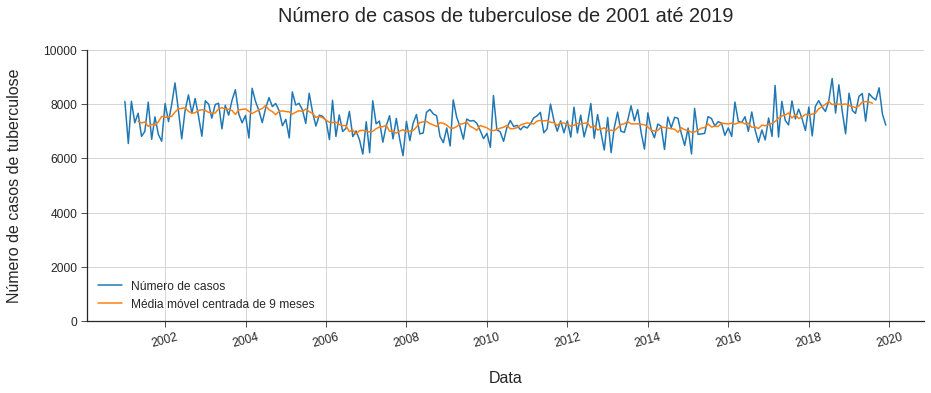

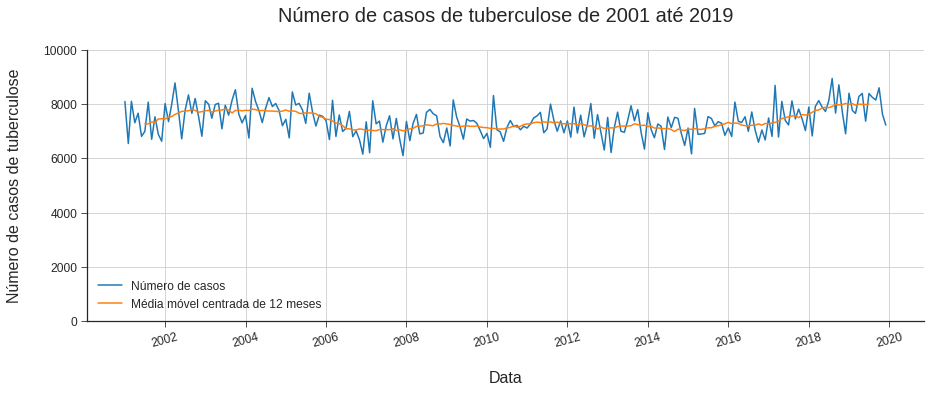

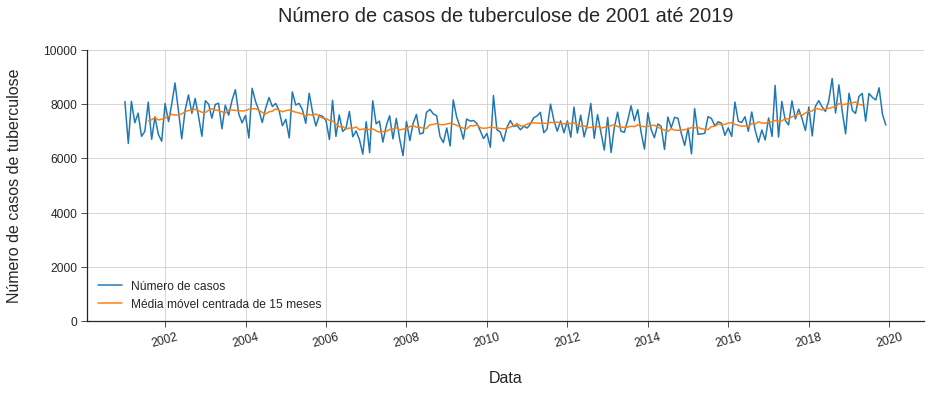

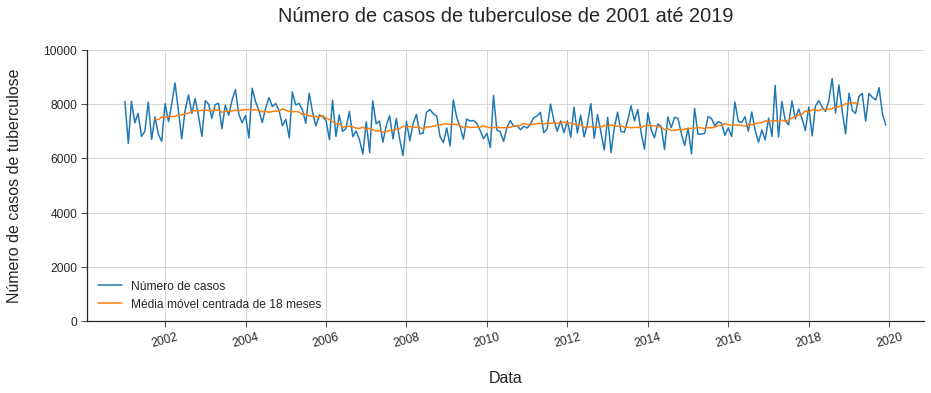

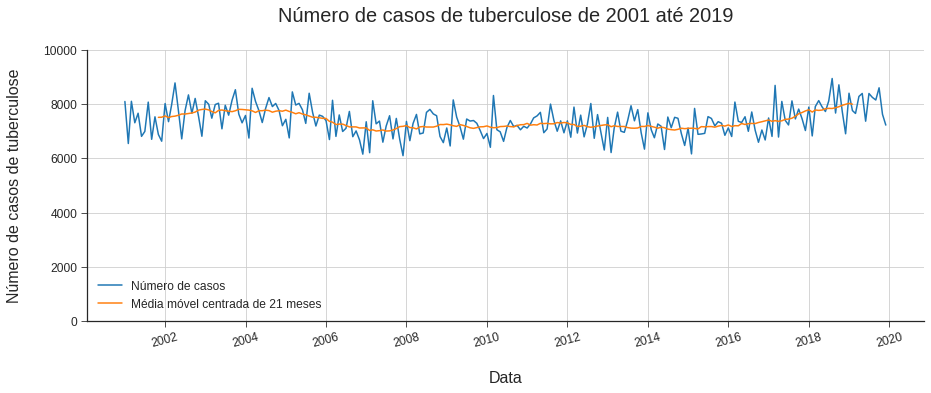

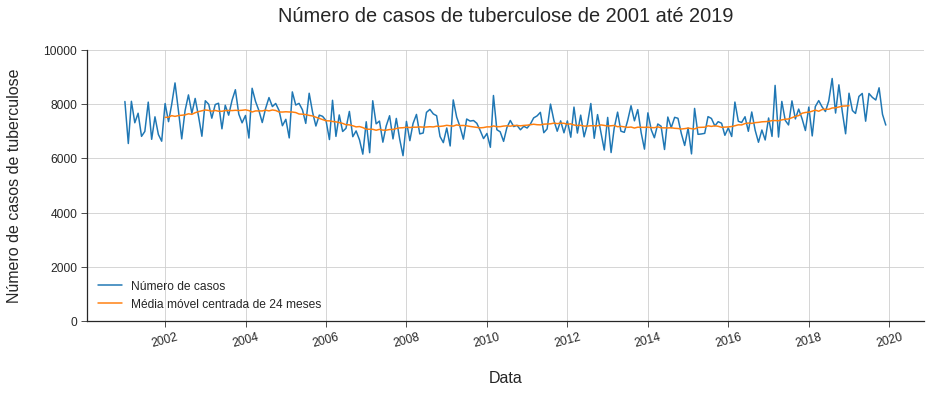

In [ ]:
meses_para_media_movel = [3, 6, 9, 12, 15, 18, 21, 24]

for mes in meses_para_media_movel:
  mostra_serie_temporal_e_media_movel_tuberculose(dados_st, mes)
  print('\n')

Quanto maior é a quantidade de meses anteriores contados para a média móvel, menos "overfittado" fica, e conseguimos ter uma estabilidade maior da linha laranja.

Entretanto, quando aumentamos muito essa quantidade, perdemos informações que podem ser importantes, e menos preciso ficaria a nossa suposta previsão.

### Desafio 02 - Pensar em como realizar sua primeira previsão usando as médias ou qualquer outra abordagem do seu interesse.

## 04. Decomposição e Autocorrelação

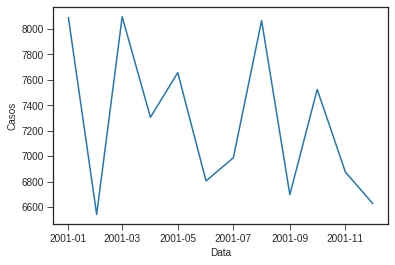

In [ ]:
sns.lineplot(x='Data', y='Casos', data=dados_st[:12])

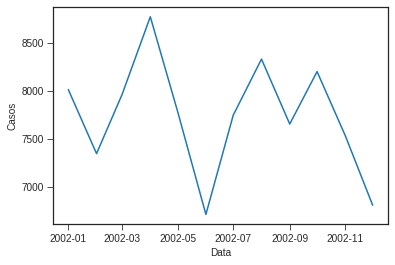

In [ ]:
sns.lineplot(x='Data', y='Casos', data=dados_st[12:24])

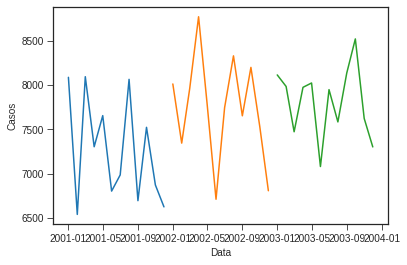

In [ ]:
sns.lineplot(x='Data', y='Casos', data=dados_st[:12])
sns.lineplot(x='Data', y='Casos', data=dados_st[12:24])
sns.lineplot(x='Data', y='Casos', data=dados_st[24:36])

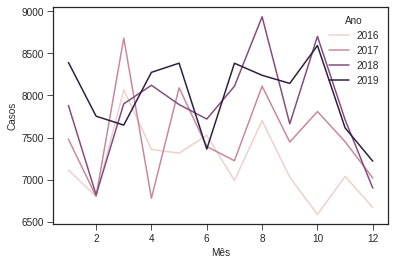

In [ ]:
dados_st['Ano'] = dados_st['Data'].dt.year
dados_st['Mês'] = dados_st['Data'].dt.month

sns.lineplot(x='Mês', y='Casos', data=dados_st.query('Ano > 2015'), hue='Ano')

In [ ]:
# Comando para calcular os gráficos do observado, da tendência, da sazonalidade e do residual
decomposicao = seasonal_decompose(dados_st[['Data', 'Casos']].set_index('Data'))

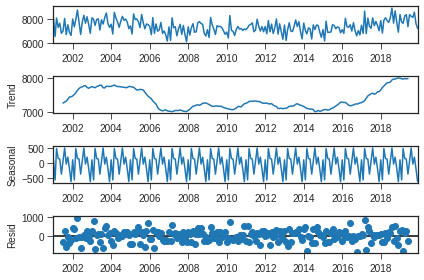

In [ ]:
decomposicao.plot();

In [ ]:
decomposicao = seasonal_decompose(dados_st[['Data', 'Casos']].set_index('Data'),
                                  model='multiplicative')

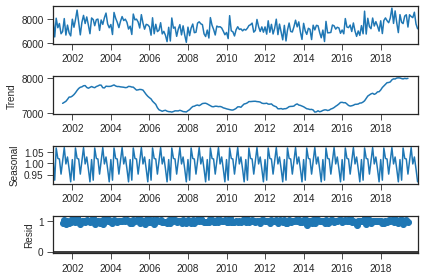

In [ ]:
decomposicao.plot();

In [ ]:
url_passageiros = 'https://raw.githubusercontent.com/alura-cursos/serie_temporal_bootcamp/main/AirPassengers.csv'

dados_passageiros = pd.read_csv(url_passageiros)
dados_passageiros.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [ ]:
dados_passageiros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
dados_passageiros['Month'] = pd.to_datetime(dados_passageiros['Month'])
dados_passageiros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


(0.0, 700.0)

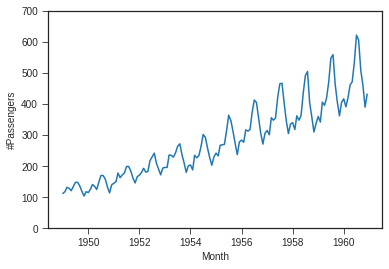

In [ ]:
sns.lineplot(x='Month', y='#Passengers', data=dados_passageiros)
plt.ylim(0, 700)

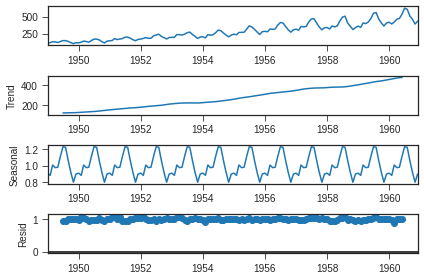

In [ ]:
decomposicao_p = seasonal_decompose(dados_passageiros.set_index('Month'),
                                    model='multiplicative')
decomposicao_p.plot();

Um conceito importante é a **Autocorrelação**, em que consiste em fazer a correlação com a mesma variável temporal, porém com dados que estão adiantadados, ou seja, com a linha movida um pouco mais pra esquerda, no gráfico. Portanto, o objetivo principal é investigar a sazonalidade dos dados, qual é o período em que explica melhor o fator de repetição dos números.

Os comandos abaixo se referem aos gráficos de autocorrelação:

- `plot_acf`: "*plot auto correlation function*"
- `plot_pacf`: "*plot partial auto correlation function*"

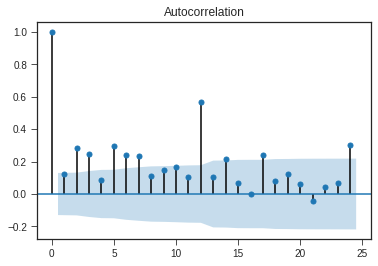

In [ ]:
plot_acf(dados_st['Casos']);

O gráfico de autocorrelação é a correlação do dia atual com um determinado período. No caso, o eixo x é representado pelos meses, pois são os períodos que cada observação de tuberculose foi observado, e no eixo y, é a correlação de fato.

Então pelo gráfico, podemos notar que a correlação mais forte do número de casos (tirando a primeira que é entre o dia atual e ele mesmo) é com um "*delay*" de 12 meses, ou seja, com 1 ano de lag, obtemos valores bem correlacionados (aproximadamente 0.6).

Além disso, observamos uma faixa azul atrás. Esta representa o intervalo de confiança das autocorrelações. Sendo assim, se a autocorrelação cai dentro dessa "nuvem", então pode ser um fator aleatório, já se está acima/abaixo dela, é um dado mais significativo (melhor correlacionado).

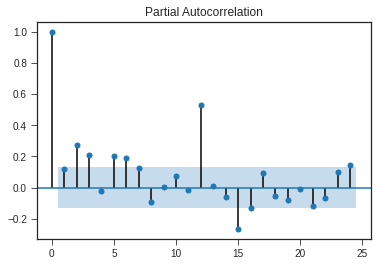

In [ ]:
plot_pacf(dados_st['Casos']);

A autocorrelação parcial é normalizada de acordo com a autocorrelação de *lag* 1, facilitando a visualização de algumas coisas.

**Observação:** explicar esses números depende de um estudo e um entendimento mais aprofundado dos dados.

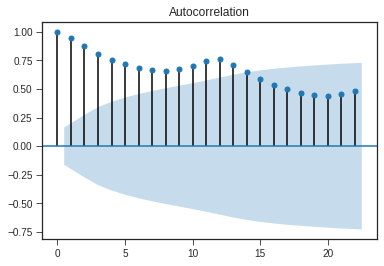

In [ ]:
plot_acf(dados_passageiros['#Passengers']);

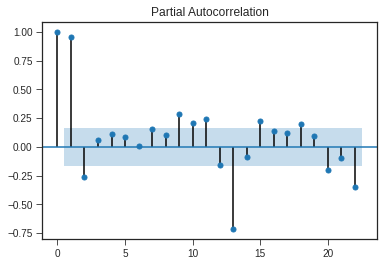

In [ ]:
plot_pacf(dados_passageiros['#Passengers']);

### Desafio 01 - Transformar as datas da base de dados em index e realizar os slices feitos em aulas pelas datas.

In [ ]:
dados_st_copia = dados_st.copy()
dados_st_copia.set_index('Data', inplace=True)
dados_st_copia.head()

Casos  Media_Movel_3  Media_Movel_6  Media_Movel_3c   Ano  Mês
Data                                                                      
2001-01-01   8088            NaN            NaN             NaN  2001    1
2001-02-01   6542            NaN            NaN     7575.000000  2001    2
2001-03-01   8095    7575.000000            NaN     7314.000000  2001    3
2001-04-01   7305    7314.000000            NaN     7685.333333  2001    4
2001-05-01   7656    7685.333333            NaN     7255.333333  2001    5

### Desafio 02 - Formatar os gráficos de decomposição, colocar título e modificar os tamanhos. realizar a decomposição de outras séries temporais como a da Hanseníase.

In [ ]:
# Função para plotar os gráficos de linha
def mostrar_grafico_de_linhas(df, x_label, y_label, titulo):
  plt.figure(figsize=(15,5))
  sns.lineplot(data=df)
  plt.legend('')
  plt.ylim(0)
  plt.xticks(rotation=15, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel(f'\n{x_label}', fontsize=16)
  plt.ylabel(f'{y_label}\n', fontsize=16)
  plt.title(f'{titulo}\n', fontsize=20)
  plt.grid()
  sns.despine()
  plt.show()

Modelo: aditive



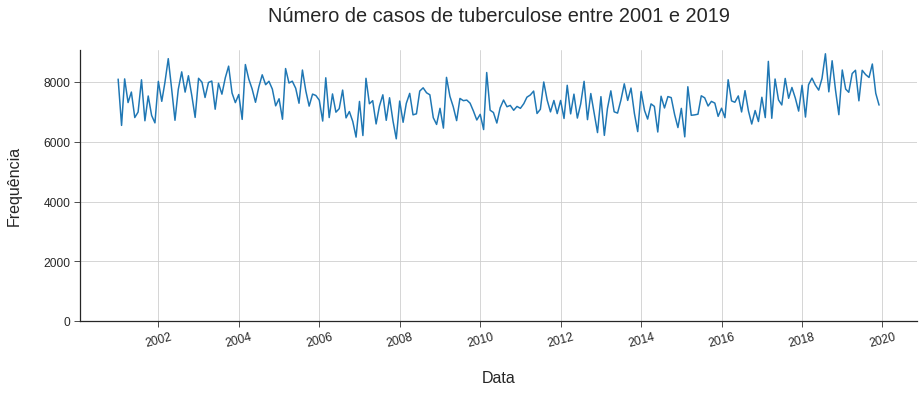

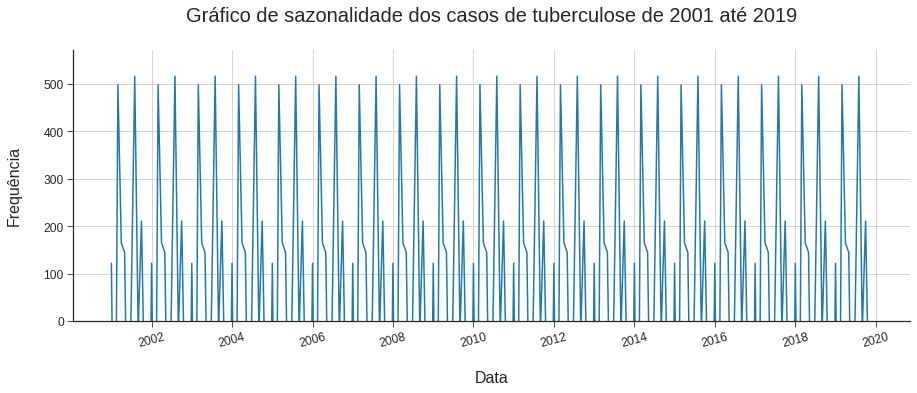

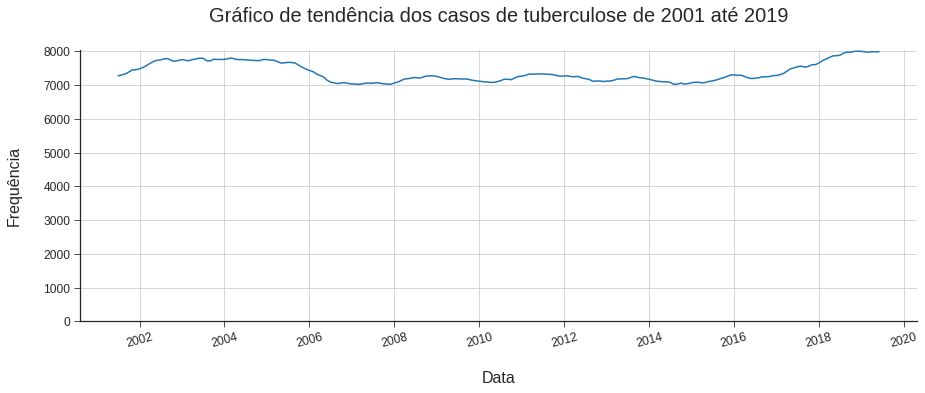

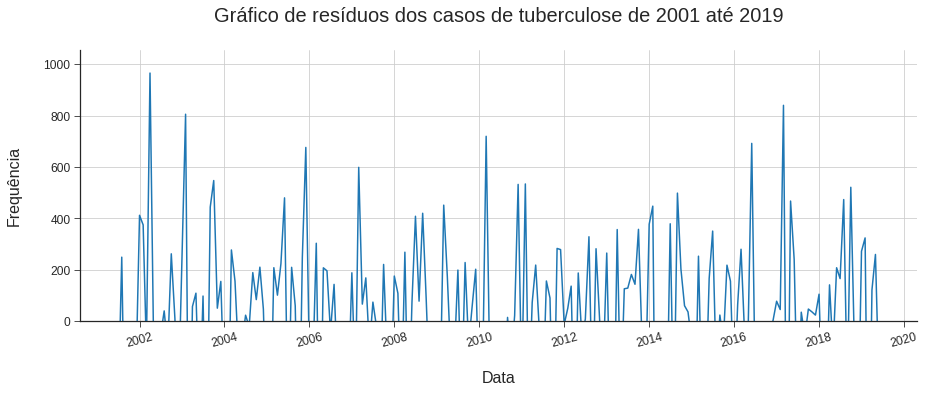



Modelo: multiplicative



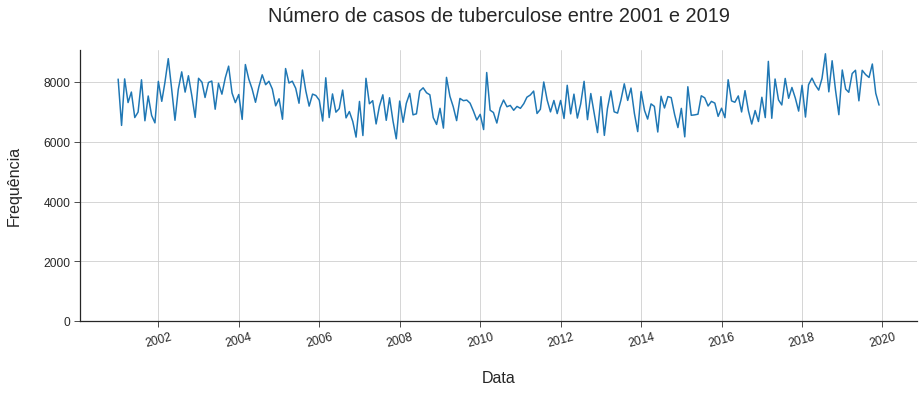

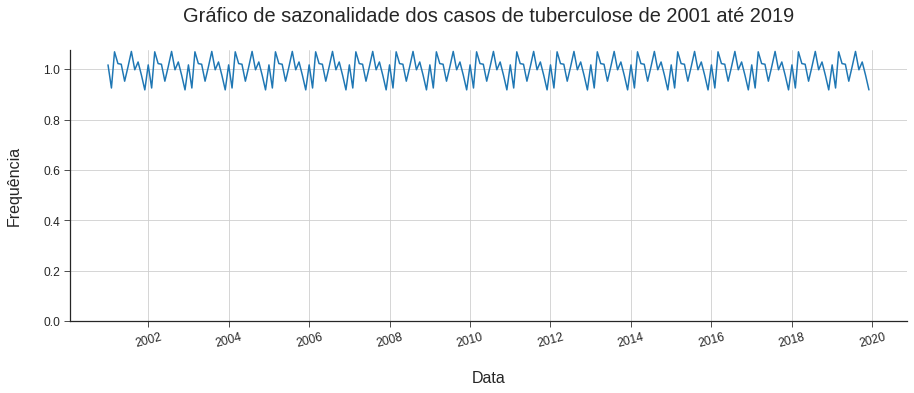

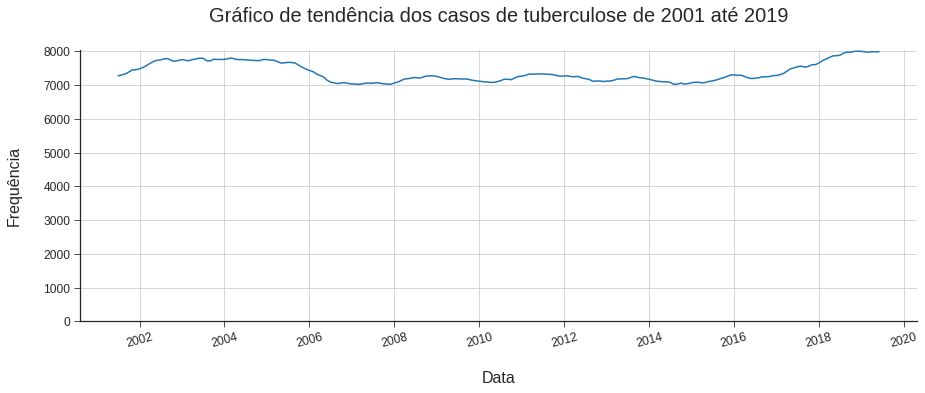

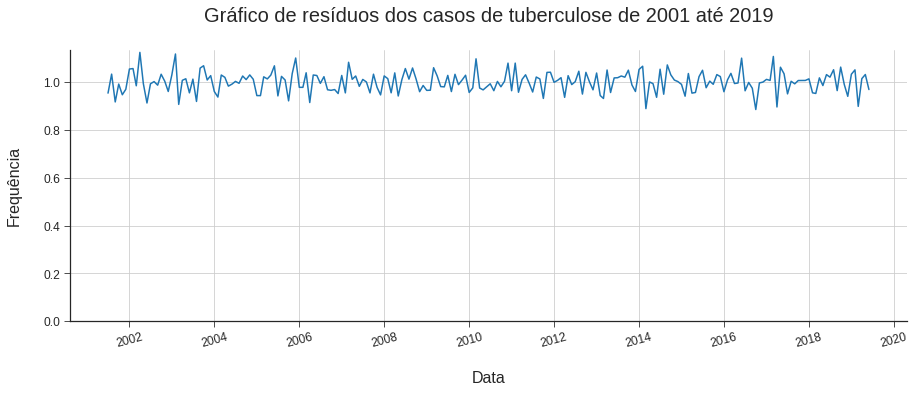

In [ ]:
modelos_st = ['aditive', 'multiplicative']
for modelo in modelos_st:
  decomposicao = seasonal_decompose(dados_st[['Data', 'Casos']].set_index('Data'),
                                    model=modelo)
  decomposicao_separado = [decomposicao.observed, decomposicao.seasonal, 
                          decomposicao.trend, decomposicao.resid]

  decomposicao_titulos = ['Número de casos de tuberculose entre 2001 e 2019',
                          'Gráfico de sazonalidade dos casos de tuberculose de 2001 até 2019',
                          'Gráfico de tendência dos casos de tuberculose de 2001 até 2019',
                          'Gráfico de resíduos dos casos de tuberculose de 2001 até 2019']

  print(f'Modelo: {modelo}')
  print()
  contador = 0
  for dado in decomposicao_separado:
    mostrar_grafico_de_linhas(dado, 'Data', 'Frequência',
                              decomposicao_titulos[contador])
    print()
    contador += 1
  print()

Para efetuar as operações com o dataframe da Hanseníase, basta utilizar o mesmo processo feito em aula.

In [ ]:
hanseniase_dt_casos = hanseniase[['Data', 'Casos']].sort_values('Data')
hanseniase_dt_casos = hanseniase_dt_casos.set_index('Data')

Modelo: aditive



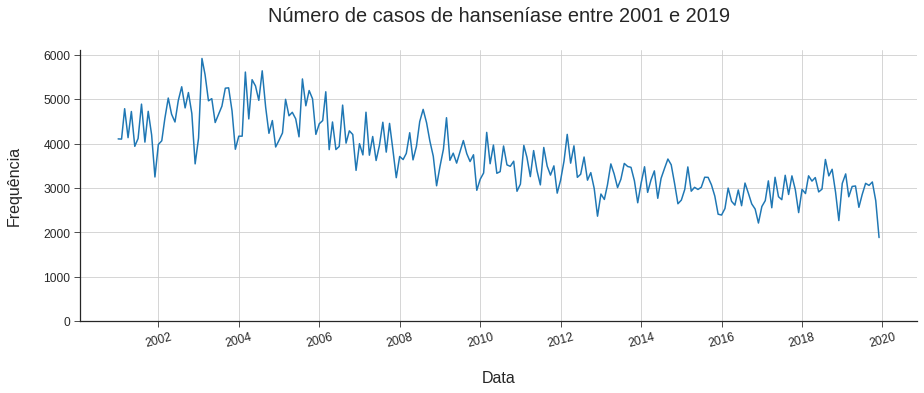

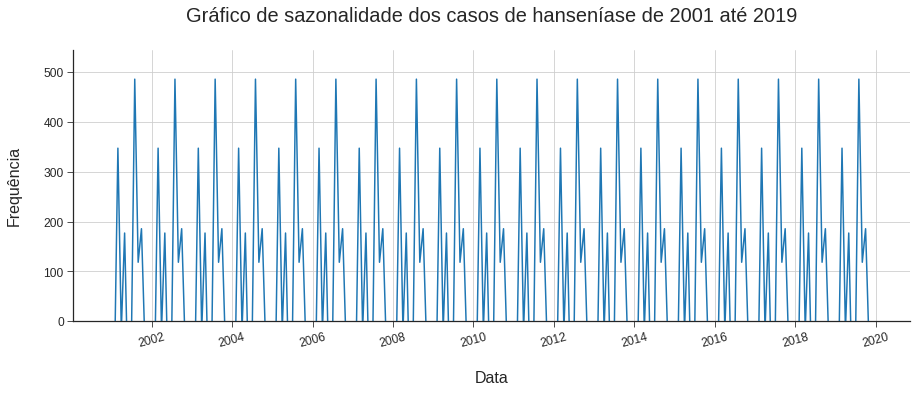

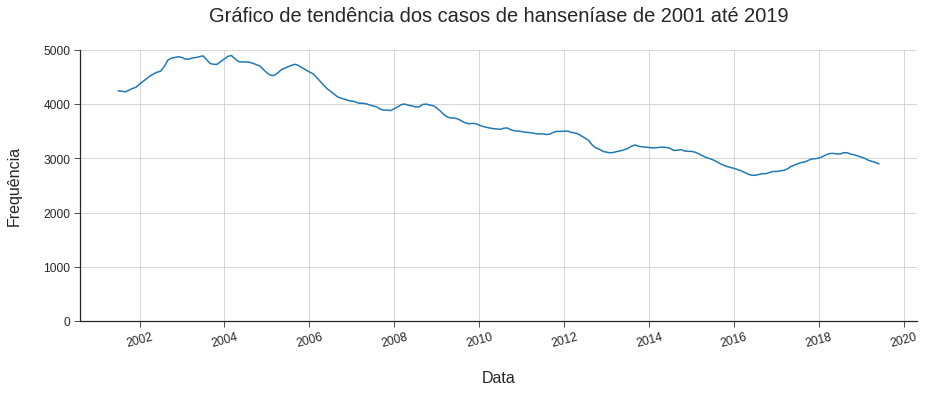

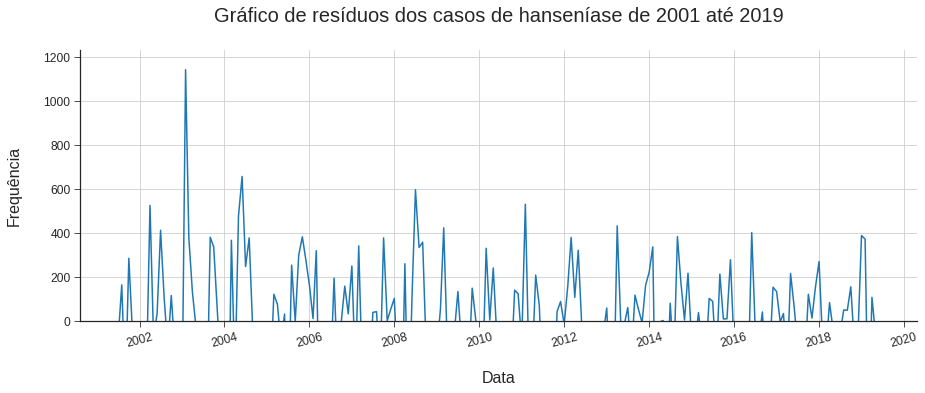



Modelo: multiplicative



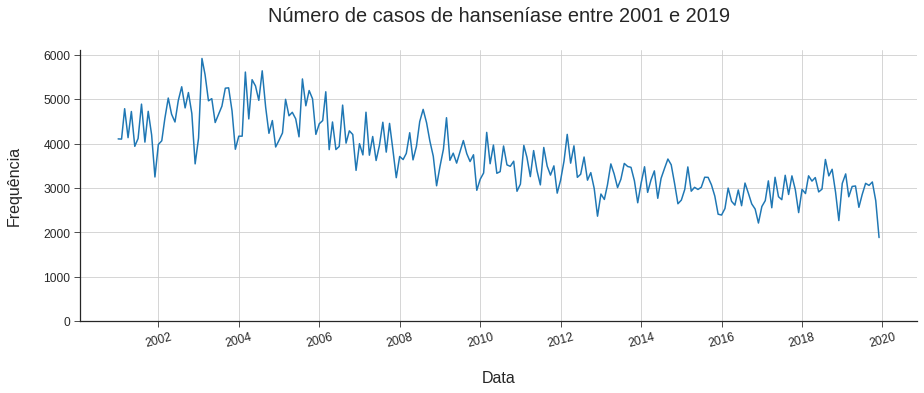

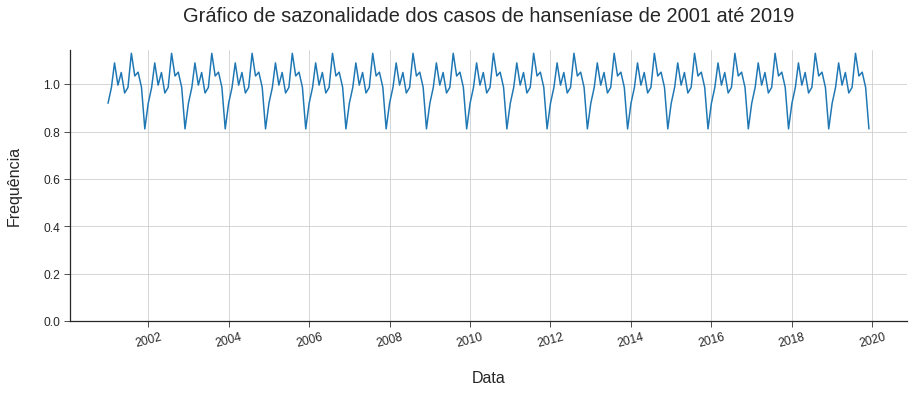

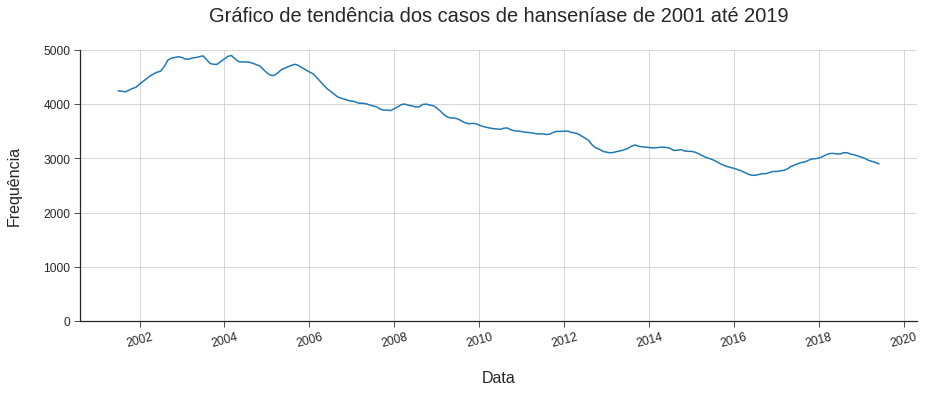

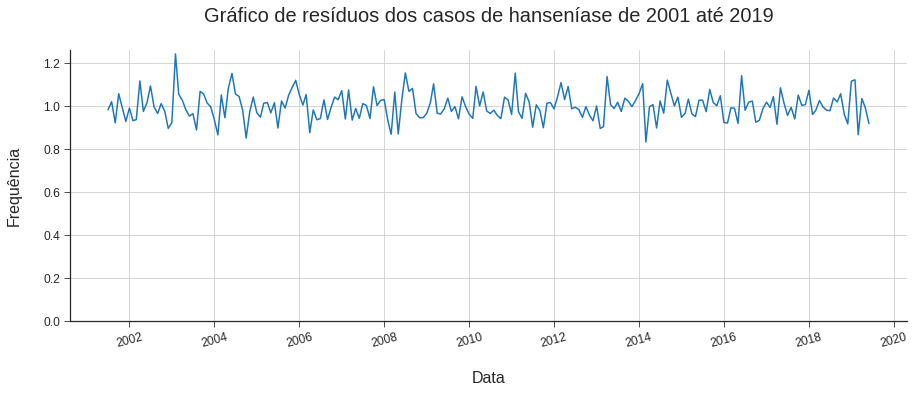

In [ ]:
modelos_st = ['aditive', 'multiplicative']
for modelo in modelos_st:
  hanseniase_decomposicao = seasonal_decompose(hanseniase_dt_casos, model=modelo)
  decomposicao_separado = [hanseniase_decomposicao.observed, 
                           hanseniase_decomposicao.seasonal, 
                           hanseniase_decomposicao.trend, 
                           hanseniase_decomposicao.resid]

  decomposicao_titulos = ['Número de casos de hanseníase entre 2001 e 2019',
                          'Gráfico de sazonalidade dos casos de hanseníase de 2001 até 2019',
                          'Gráfico de tendência dos casos de hanseníase de 2001 até 2019',
                          'Gráfico de resíduos dos casos de hanseníase de 2001 até 2019']

  print(f'Modelo: {modelo}')
  print()
  contador = 0
  for dado in decomposicao_separado:
    mostrar_grafico_de_linhas(dado, 'Data', 'Frequência',
                              decomposicao_titulos[contador])
    print()
    contador += 1
  print()

### Desafio 09 - Realizar uma análise de autocorrelação e autocorrelação parcial nos dados da COVID-19, interpretar e discutir no discord.

In [ ]:
url_covid = '/content/drive/MyDrive/Alura Bootcamp DS/Módulo 4/COVIDBR_21jan2021.csv'
covid = pd.read_csv(url_covid, encoding='ISO-8859-1', sep=';',
                    decimal=',', thousands='.')
covid.head()

regiao estado  ... emAcompanhamentoNovos  interior/metropolitana
0  Brasil    NaN  ...                   NaN                     NaN
1  Brasil    NaN  ...                   NaN                     NaN
2  Brasil    NaN  ...                   NaN                     NaN
3  Brasil    NaN  ...                   NaN                     NaN
4  Brasil    NaN  ...                   NaN                     NaN

[5 rows x 17 columns]

In [ ]:
covid.tail()

regiao estado  ... emAcompanhamentoNovos  interior/metropolitana
1692184  Centro-Oeste     DF  ...                   NaN                     1.0
1692185  Centro-Oeste     DF  ...                   NaN                     1.0
1692186  Centro-Oeste     DF  ...                   NaN                     1.0
1692187  Centro-Oeste     DF  ...                   NaN                     1.0
1692188  Centro-Oeste     DF  ...                   NaN                     1.0

[5 rows x 17 columns]

In [ ]:
# Selecionando apenas os valores de COVID-19 do Brasil
covid_br_novos_casos = covid.query('regiao == "Brasil"')[['data', 'casosNovos']]
covid_br_novos_casos.head()

data  casosNovos
0  2020-02-25           0
1  2020-02-26           1
2  2020-02-27           0
3  2020-02-28           0
4  2020-02-29           1

In [ ]:
# Não existem valores faltantes nesse dataframe
covid_br_novos_casos.isna().sum()

data          0
casosNovos    0
dtype: int64

In [ ]:
covid_br_novos_casos['data'] = pd.to_datetime(covid_br_novos_casos['data'])
covid_br_novos_casos.sort_values('data', inplace=True)
covid_br_novos_casos.set_index('data', inplace=True)
covid_br_novos_casos.head()

casosNovos
data                  
2020-02-25           0
2020-02-26           1
2020-02-27           0
2020-02-28           0
2020-02-29           1

In [ ]:
covid_br_novos_casos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 2020-02-25 to 2021-01-21
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   casosNovos  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


Modelo: aditivo



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


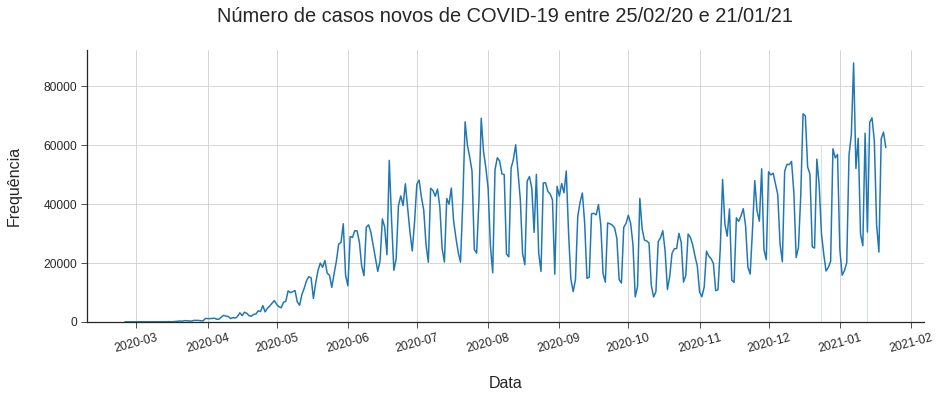

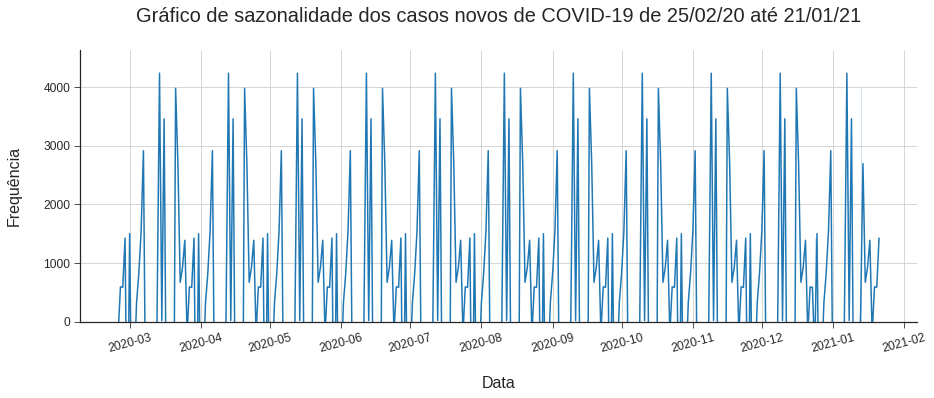

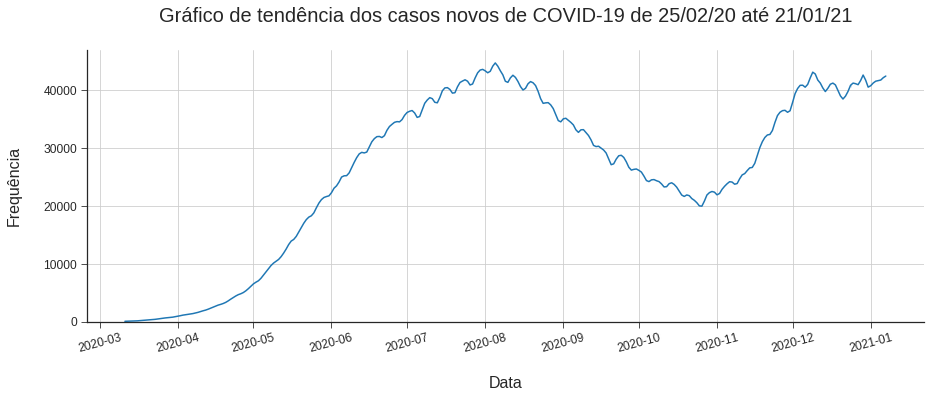

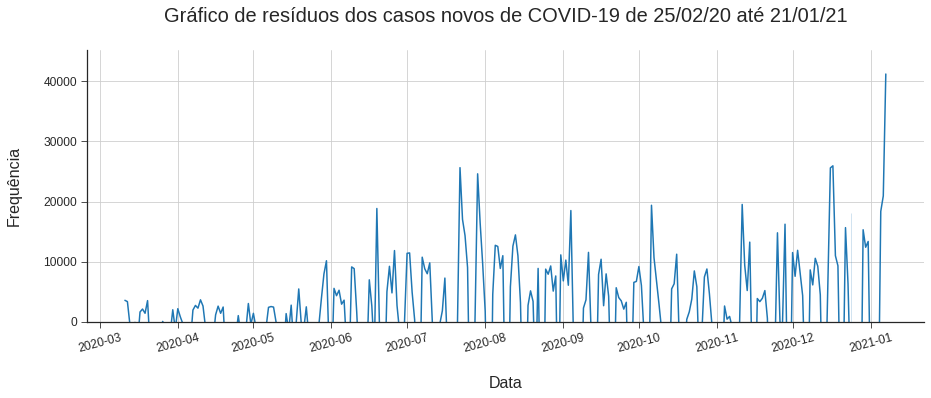

In [ ]:
# Decomposicao da serie temporal, modelo aditivo
decomposicao_covid = seasonal_decompose(covid_br_novos_casos, freq=30)

decomposicao_covid_separado = [decomposicao_covid.observed, 
                               decomposicao_covid.seasonal, 
                               decomposicao_covid.trend, 
                               decomposicao_covid.resid]

decomposicao_covid_titulos = ['Número de casos novos de COVID-19 entre 25/02/20 e 21/01/21',
                              'Gráfico de sazonalidade dos casos novos de COVID-19 de 25/02/20 até 21/01/21',
                              'Gráfico de tendência dos casos novos de COVID-19 de 25/02/20 até 21/01/21',
                              'Gráfico de resíduos dos casos novos de COVID-19 de 25/02/20 até 21/01/21']

print('Modelo: aditivo')
print()
contador = 0
for dado in decomposicao_covid_separado:
  mostrar_grafico_de_linhas(dado, 'Data', 'Frequência',
                            decomposicao_covid_titulos[contador])
  print()
  contador += 1
print()

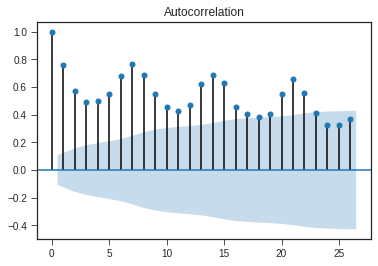

In [ ]:
plot_acf(covid_br_novos_casos);

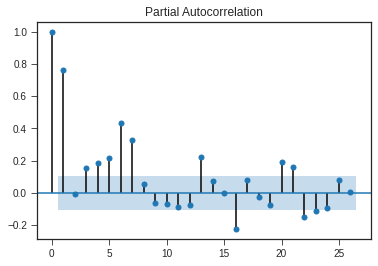

In [ ]:
plot_pacf(covid_br_novos_casos);

Podemos ver então que a autocorrelação que melhor descreve os nossos casos de COVID-19 é o de 1 dia.

## 05. Previsões em Séries Temporais

In [ ]:
dados_passageiros.rename({'Month':'Data', '#Passengers': 'Passageiros'}, 
                         axis=1, inplace=True)
dados_passageiros['Mês'] = dados_passageiros['Data'].dt.month
dados_passageiros['Ano'] = dados_passageiros['Data'].dt.year

dados_passageiros.head()

Data  Passageiros  Mês   Ano
0 1949-01-01          112    1  1949
1 1949-02-01          118    2  1949
2 1949-03-01          132    3  1949
3 1949-04-01          129    4  1949
4 1949-05-01          121    5  1949

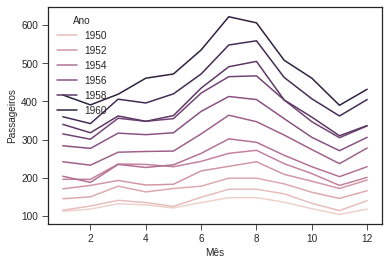

In [ ]:
sns.lineplot(x='Mês', y='Passageiros', data=dados_passageiros, hue='Ano')

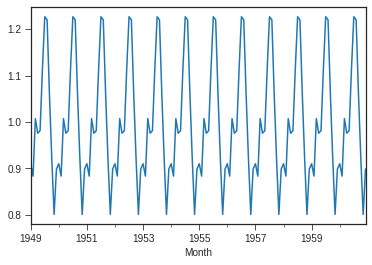

In [ ]:
decomposicao_p.seasonal.plot()
plt.legend('')

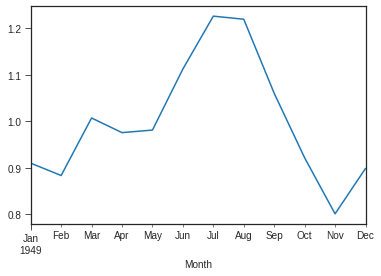

In [ ]:
decomposicao_p.seasonal[:12].plot()

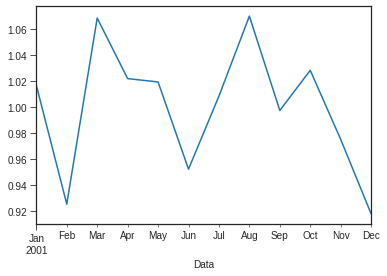

In [ ]:
decomposicao.seasonal[:12].plot()

### Modelo ARIMA (Autoregressive Integrated Moving Average)
#### O que é e algumas codições
Método estatístico que utiliza autoregressão e médias móveis para previsão (*forecasting*) de séries temporais. Ela requer 2 condições:
- **Estacionariedade** das medidas observadas;
- Número mínimo de **40** observações.

#### Passos para o ARIMA
1. Análise das condições e dos ajustes:
  - **Análise gráfica** (ACF e PACF) e **Teste Ljung-Box Q** da variável Y ($H_0$: não há autocorrelação);
2. Verificar o valor do *Lag*;
3. Colocar o banco de dados em ordem temporal adequada;
4. Estabelecimento do modelo ARIMA (p, d, q);
5. Aplicar o modelo;
6. Análise da qualidade do modelo:
  - **AIC/BIC** para modelos com mesma ordem (p, d, q iguais);
  - **RMSE** para modelos com p, d, q diferentes.
  
  Repetir os passos de 4 a 6 até encontrar o modelo com o melhor parâmetro.
7. Descrever o *forecasting*, ou seja, mostrar se a previsão ficou boa no final.

**Observação:** Quanto menor o AIC/BIC e o RMSE, melhor são os modelos!
#### Mas afinal, o que são esses parâmetros p, d, q?

- **p** (**AR**): O **número de *lags*** que devem ser incluídos no modelo (um jeito para descobrir é olhando o gráfico *pacf*).

- **d** (**I**): O **número de diferenças** tomadas na série. É como se fosse o número de padrões diferentes que encontramos na nossa série, por exemplo, se a nossa série possui um padrão com uma amplitude alta e outro padrão com amplitude baixa, existem 2 padrões distintos, ou seja, d = 2. Sendo assim, se a sua série é estacionária e você a considera constante, o d = 0 (sem diferenças), caso haja sazonalidade (mudança de frequências), podemos colocar qualquer valor diferente de 0.

- **q** (**MA**): Ordem do componente das médias móveis (um jeito para descobrir é olhando o gráfico *acf*). Ele é muito vinculado com o valor dos **lags**, sendo assim, **geralmente** o mesmo valor de **p** é **igual** o de **q**!

Podemos usar um valor 0 para desligar um parâmetro, dessa forma, aquela função em questão não será feita, por exemplo, se no parâmetro d definirmos 0 não será realizada uma diferenciação nos dados. Neste exemplo teríamos um modelo ARMA.

#### Alguns modelos manjados
- ARIMA(0, 1, 0) - Passeio aleatório;
- ARIMA(0, 0, 0) - Ruído Branco (constante, sem nenhuma relação com outras variáveis).

Um link que pode ajudar a entender melhor é [esse](https://fr.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html).

Fonte: https://www.youtube.com/watch?v=qTQ1YDgyByE

### Modelo SARIMA (ARIMA Sazonal)
- p, d, q: características da série em si (mesmas do ARIMA normal);
- P, D, Q: características da **Sazonalidade** do evento.

É "como se existissem 2 ARIMA's", um para os momentos de **baixa** e outro para os momentos de **alta**. Sendo assim, existem o p, d, q minúsculos e maiúsculos.

- Tipos de Sazonalidade:
  - Aditiva: o "como se aumenta" se mantém constante;
  - Multiplicativa o "como se aumenta" é de forma multiplicativa.

  <img src="https://kourentzes.com/forecasting/wp-content/uploads/2014/11/mseas.fig1_.png">

In [ ]:
modelo_arima = ARIMA(dados_st['Casos'].values.astype('float32'), order=[0, 0, 0])
modelo_arima_treinado = modelo_arima.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
modelo_arima_treinado.forecast(12)

(array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
        7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
        7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772]),
 array([567.21170306, 567.21170306, 567.21170306, 567.21170306,
        567.21170306, 567.21170306, 567.21170306, 567.21170306,
        567.21170306, 567.21170306, 567.21170306, 567.21170306]),
 array([[6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734],
        [6277.5705781 , 8500.99959734]]))

In [ ]:
# Primeiro array
modelo_arima_treinado.forecast(12)[0]

array([7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772,
       7389.28508772, 7389.28508772, 7389.28508772, 7389.28508772])

O primeiro *array* (0) é a "previsão" dos dados futuros! (Na verdade é uma previsão baseada na média do número de casos.)

In [ ]:
# Realmente a previsão é a média dos casos!
dados_st['Casos'].mean()

7389.285087719299

In [ ]:
dados_treino = dados_st.query('Ano != 2019')
dados_teste = dados_st.query('Ano == 2019')

modelo_arima = ARIMA(dados_treino['Casos'].values.astype('float32'), order=[0, 0, 0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


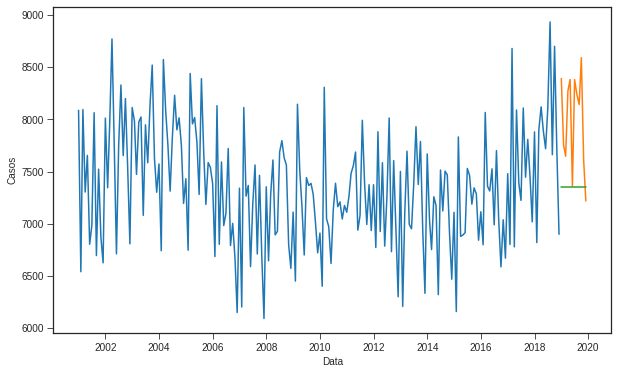

In [ ]:
dados_teste['previsao'] = previsao
plt.figure(figsize=(10, 6))
sns.lineplot(x='Data', y='Casos', data=dados_treino)
sns.lineplot(x='Data', y='Casos', data=dados_teste)
sns.lineplot(x='Data', y='previsao', data=dados_teste)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

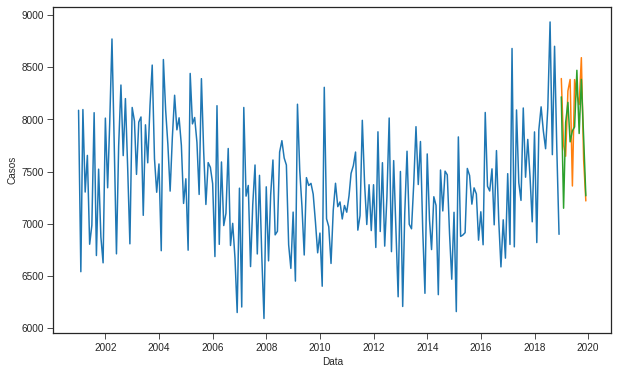

In [ ]:
# Testando valores
modelo_arima = ARIMA(dados_treino['Casos'].values.astype('float32'), order=[12, 1, 2])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

dados_teste['previsao'] = previsao
plt.figure(figsize=(10, 6))
sns.lineplot(x='Data', y='Casos', data=dados_treino)
sns.lineplot(x='Data', y='Casos', data=dados_teste)
sns.lineplot(x='Data', y='previsao', data=dados_teste)

### Desafio 01 - Tentar resolver o problema de plots de imagem antes de assistir o vídeo com a resolução.

### Desafio 02 - Na tupla de retorno do forecast, estudar na documentação o que são cada um dos elementos de retorno.

Pela documentação, diz que o retorno dessa função é:
- `forecast` : array (elemento **0**)
    - Array of out of sample forecasts.
- `stderr` : array (elemento **1**)
    - Array of the standard error of the forecasts.
- `conf_int` : array (elemento **2**)
    - 2d array of the confidence interval for the forecast.

### Desafio 03 -Utilizar o modelo ARIMA para a base de dados de passageiros e modificar o parâmetro order.

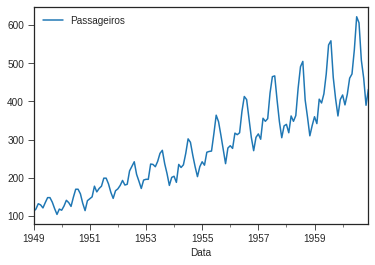

In [ ]:
dados_passageiros.plot(x='Data', y='Passageiros')

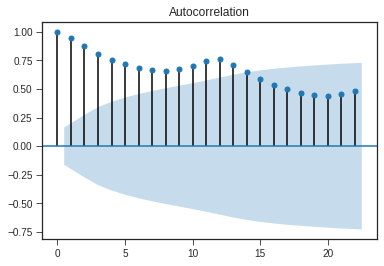

In [ ]:
plot_acf(dados_passageiros['Passageiros']);

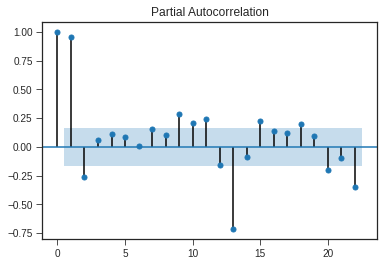

In [ ]:
plot_pacf(dados_passageiros['Passageiros']);

In [ ]:
dados_passageiros.tail()

Data  Passageiros  Mês   Ano
139 1960-08-01          606    8  1960
140 1960-09-01          508    9  1960
141 1960-10-01          461   10  1960
142 1960-11-01          390   11  1960
143 1960-12-01          432   12  1960

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

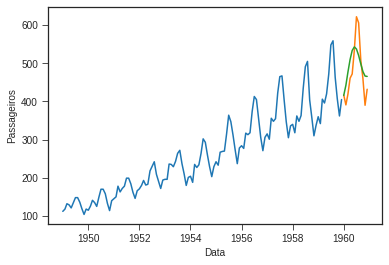

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

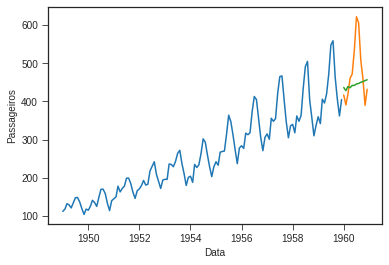

In [ ]:
# Testando alguns valores
dados_treino_p = dados_passageiros.query('Ano != 1960')
dados_teste_p = dados_passageiros.query('Ano == 1960')


for i in range(1, 3):
  modelo_arima_p = ARIMA(dados_treino_p['Passageiros'].values.astype('float32'), 
                        order=[2, i, 2])
  modelo_arima_p_treinado = modelo_arima_p.fit()
  previsao_passageiros = modelo_arima_p_treinado.forecast(12)[0]
  dados_teste_p['previsao'] = previsao_passageiros

  sns.lineplot(x='Data', y='Passageiros', data=dados_treino_p)
  sns.lineplot(x='Data', y='Passageiros', data=dados_teste_p)
  sns.lineplot(x='Data', y='previsao', data=dados_teste_p)
  plt.show()

### Desafio 04 - Calcula uma série temporal diferenciada de 1 e 2 ordem e plotar os gráficos destas séries para verificar o efeito do parâmetro de diferenciação do ARIMA.

## 06. AUTOARIMA e Prophet

In [ ]:
# error_action: ignora os erros que ocorriam anteriormente
# trace: mostra todos os testes
# seasonal: inclui o fator de sazonalidade
# m: se os seus dados forem mensais, coloque o m = 12
modelo_autoarima = auto_arima(dados_treino['Casos'].values, 
                              error_action='ignore', trace=True,
                              seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=2.00 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.58 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.26 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=2.59 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=1.02 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3

**AIC** é uma métrica que usamos para medir a diferença da série temporal que estamos ajustando e os dados própriamente ditos.

Quanto **menor** o AIC, **melhor** é o modelo!

**Observação:** os modelos **P**, **D**, **Q** maiúsculos modelam o nosso fator de sazonalidade.

In [ ]:
modelo_autoarima.predict(12)

array([8159.98112671, 7481.16437183, 7963.33559255, 8121.14059974,
       7988.91051071, 7904.76381516, 8176.77704736, 8490.76305546,
       7925.54099216, 8480.63767896, 7961.66783448, 7587.81571076])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


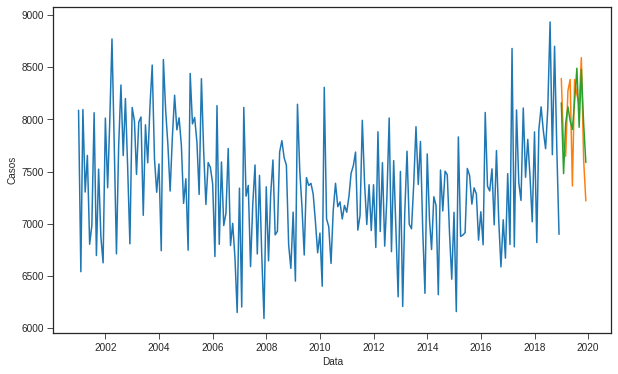

In [ ]:
previsao_autoarima = modelo_autoarima.predict(12)
dados_teste['previsao_autoarima'] = previsao_autoarima
plt.figure(figsize=(10, 6))
sns.lineplot(x='Data', y='Casos', data=dados_treino)
sns.lineplot(x='Data', y='Casos', data=dados_teste)
sns.lineplot(x='Data', y='previsao_autoarima', data=dados_teste)

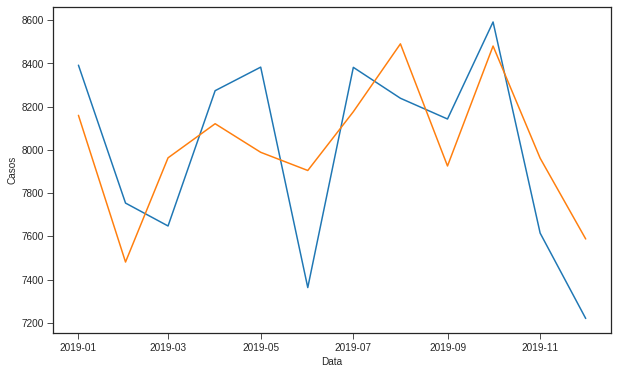

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Data', y='Casos', data=dados_teste)
sns.lineplot(x='Data', y='previsao_autoarima', data=dados_teste)

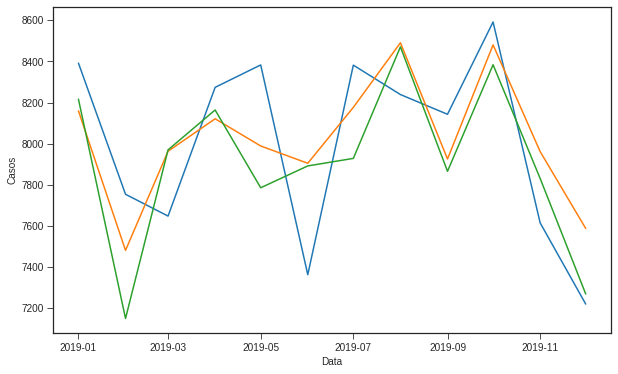

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Data', y='Casos', data=dados_teste)
sns.lineplot(x='Data', y='previsao_autoarima', data=dados_teste)
sns.lineplot(x='Data', y='previsao', data=dados_teste)

In [ ]:
resultado_autoarima = mean_squared_error(dados_teste['Casos'], 
                                         dados_teste['previsao_autoarima'])
resultado_arima = mean_squared_error(dados_teste['Casos'],
                                     dados_teste['previsao'])
print(f'Autoarima = {resultado_autoarima}')
print(f'Arima = {resultado_arima}')

Autoarima = 93378.93285752926
Arima = 131384.4418748081


**Observação:** quanto menor o erro quadrático, melhor é o modelo!

In [ ]:
modelo_profeta = Prophet()
mapa = {'Data':'ds', 'Passageiros':'y'}
dados_treino_p_profeta = dados_treino_p[['Data', 'Passageiros']].rename(mapa,
                                                                        axis=1)
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_p_profeta)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12, freq='M')
futuro

ds
0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
..         ...
139 1960-07-31
140 1960-08-31
141 1960-09-30
142 1960-10-31
143 1960-11-30

[144 rows x 1 columns]

In [ ]:
resultado_profeta = modelo_profeta_treinado.predict(futuro)
resultado_profeta

ds       trend  ...  multiplicative_terms_upper        yhat
0   1949-01-01  108.446107  ...                         0.0   83.721210
1   1949-02-01  110.624181  ...                         0.0   76.241626
2   1949-03-01  112.591474  ...                         0.0  115.696885
3   1949-04-01  114.769548  ...                         0.0  109.000900
4   1949-05-01  116.877362  ...                         0.0  111.497871
..         ...         ...  ...                         ...         ...
139 1960-07-31  467.254909  ...                         0.0  533.597470
140 1960-08-31  470.249335  ...                         0.0  482.866594
141 1960-09-30  473.147167  ...                         0.0  445.987064
142 1960-10-31  476.141594  ...                         0.0  414.486076
143 1960-11-30  479.039426  ...                         0.0  450.566353

[144 rows x 16 columns]

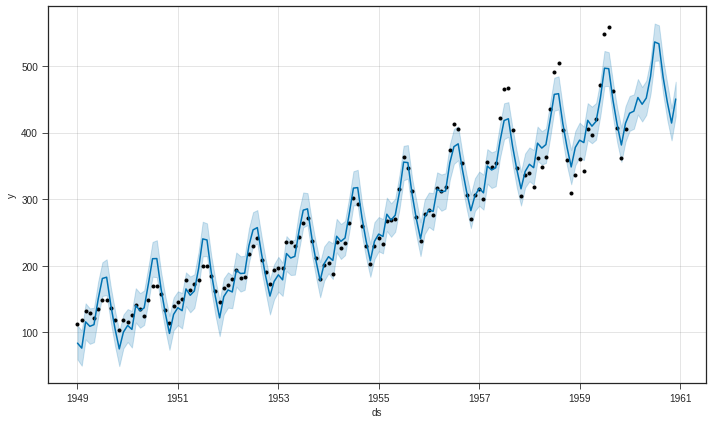

In [ ]:
# Modelo aditivo
modelo_profeta_treinado.plot(resultado_profeta);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


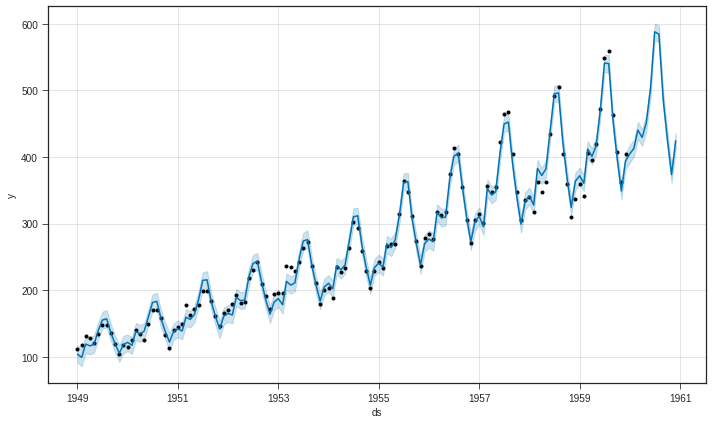

In [ ]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')
mapa = {'Data':'ds', 'Passageiros':'y'}
dados_treino_p_profeta = dados_treino_p[['Data', 'Passageiros']].rename(mapa,
                                                                        axis=1)
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_p_profeta)
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12, freq='M')
resultado_profeta = modelo_profeta_treinado.predict(futuro)

# Modelo multiplicativo
modelo_profeta_treinado.plot(resultado_profeta);

Os pontos desse gráfico são os valores reais do nosso dataframe. Já a linha em azul é a previsão do Prophet, e a faixa no fundo é o intervalo de confiança para a nossa previsão.

### Desafio 01- Variar os parâmetros max_p,d,q para verificar os efeitos no resultados.

In [ ]:
# Teste
# modelo_autoarima_teste = auto_arima(dados_treino['Casos'].values, 
                                     #error_action='ignore', trace=True,
                                     #max_p=12, max_d=4, max_q=12,
                                     #seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=1.89 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.20 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=2.43 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=0.94 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3

 ### Desafio 02 - Testar vários parâmetros para os dados de passageiros.

In [ ]:
modelo_autoarima_p = auto_arima(dados_treino_p['Passageiros'].values,
                                error_action='ignore', trace=True,
                                seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.65 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.46 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [ ]:
modelo_autoarima_p.predict(12)

array([419.967172  , 399.84985049, 457.99438118, 444.47415565,
       464.78917863, 514.12544051, 587.8041693 , 597.01082232,
       499.53126876, 442.35967856, 396.41021685, 438.65159514])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


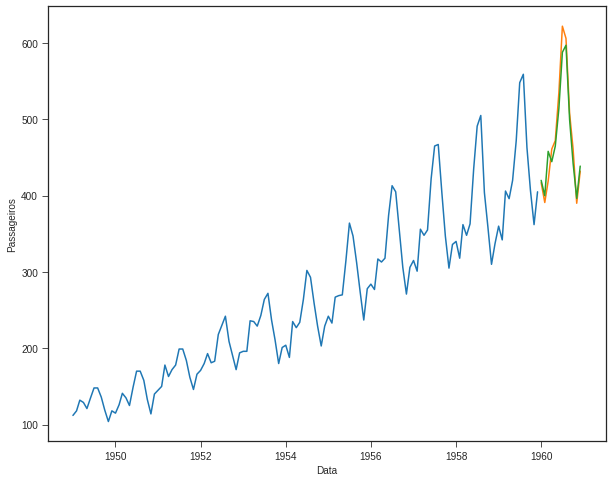

In [ ]:
dados_teste_p['previsao_autoarima'] = modelo_autoarima_p.predict(12)

plt.figure(figsize=(10, 8))
sns.lineplot(x='Data', y='Passageiros', data=dados_treino_p)
sns.lineplot(x='Data', y='Passageiros', data=dados_teste_p)
sns.lineplot(x='Data', y='previsao_autoarima', data=dados_teste_p)

### Desafio 03 - Plotar os valores reais e valores previstos pelo ¨profeta¨. Fazer a mesma análise para os dados de tuberculose e compartilhar os resultado.

In [ ]:
resultado_profeta.tail()

ds       trend  ...  additive_terms_upper        yhat
139 1960-07-31  464.860836  ...                   0.0  584.512761
140 1960-08-31  467.660516  ...                   0.0  486.857711
141 1960-09-30  470.369885  ...                   0.0  427.400268
142 1960-10-31  473.169565  ...                   0.0  373.529040
143 1960-11-30  475.878934  ...                   0.0  424.312896

[5 rows x 16 columns]

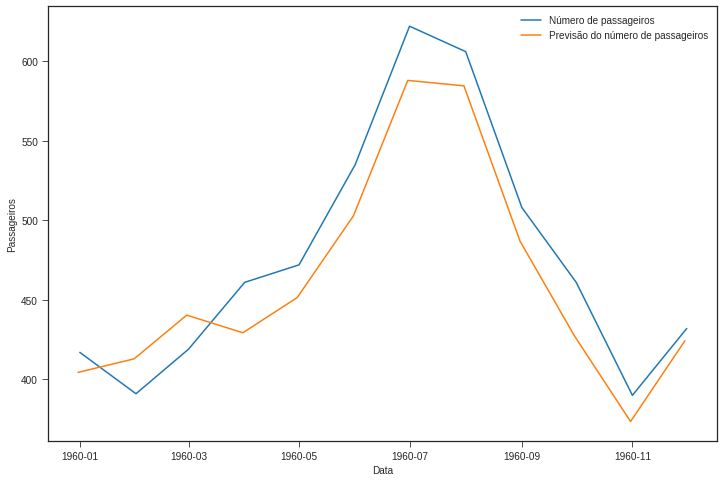

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Data', y='Passageiros', data=dados_passageiros[-12:], 
                  label='Número de passageiros')
sns.lineplot(data=resultado_profeta[-12:], x='ds', y='yhat', 
             label='Previsão do número de passageiros')

In [ ]:
dados_teste.head()

Data  Casos  Media_Movel_3  ...  Mês     previsao  previsao_autoarima
216 2019-01-01   8392    7667.666667  ...    1  8216.642409         8159.981127
217 2019-02-01   7754    7682.000000  ...    2  7149.994268         7481.164372
218 2019-03-01   7648    7931.333333  ...    3  7970.019660         7963.335593
219 2019-04-01   8274    7892.000000  ...    4  8163.988397         8121.140600
220 2019-05-01   8383    8101.666667  ...    5  7785.686619         7988.910511

[5 rows x 9 columns]

In [ ]:
modelo_profeta = Prophet()
mapa = {'Data':'ds', 'Casos':'y'}
dados_treino_profeta = dados_treino[['Data', 'Casos']].rename(mapa, axis=1)
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_profeta)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


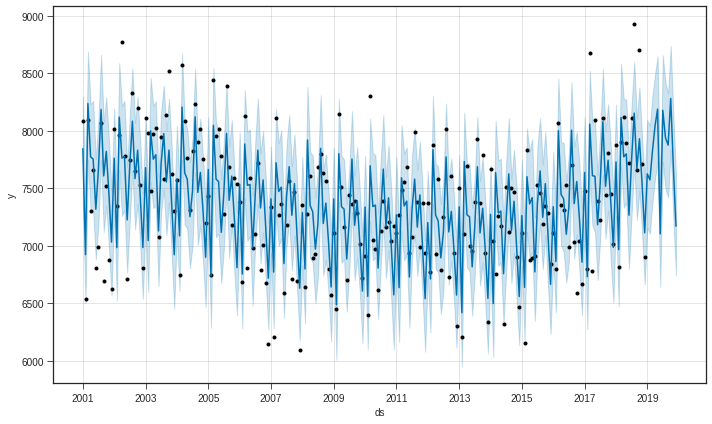

In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12, freq='M')
resultado_profeta = modelo_profeta_treinado.predict(futuro)

modelo_profeta_treinado.plot(resultado_profeta);

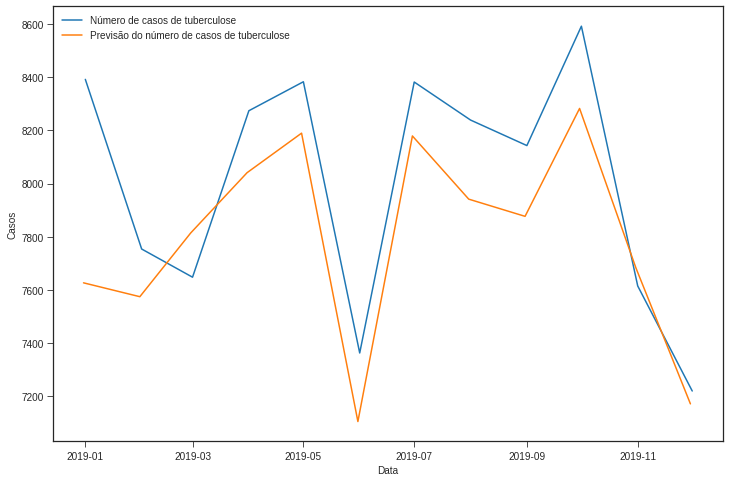

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Data', y='Casos', data=dados_st[-12:], 
                  label='Número de casos de tuberculose')
sns.lineplot(data=resultado_profeta[-12:], x='ds', y='yhat', 
             label='Previsão do número de casos de tuberculose')

In [ ]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')
mapa = {'Data':'ds', 'Casos':'y'}
dados_treino_profeta = dados_treino[['Data', 'Casos']].rename(mapa, axis=1)
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_profeta)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


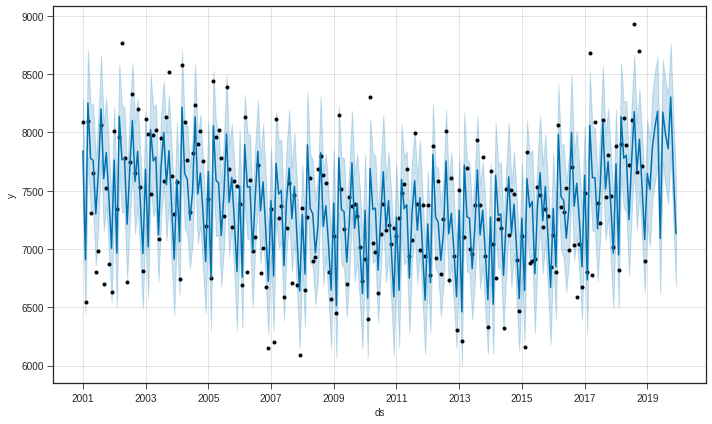

In [ ]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12, freq='M')
resultado_profeta = modelo_profeta_treinado.predict(futuro)

modelo_profeta_treinado.plot(resultado_profeta);

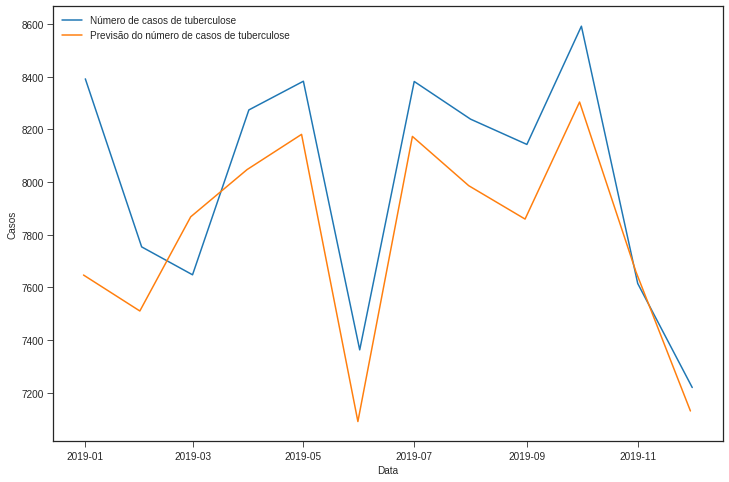

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Data', y='Casos', data=dados_st[-12:], 
                  label='Número de casos de tuberculose')
sns.lineplot(data=resultado_profeta[-12:], x='ds', y='yhat', 
             label='Previsão do número de casos de tuberculose')

### Desafio Extra - Neste módulo passamos por muitos conteúdos, para se aprofundar recomendo que pesquise mais sobre os assuntos abordados para consolidar ainda mais seus conhecimentos. Não deixe de ler e explorar mais a biblioteca prophet que é muita rica de conteúdo.